In [1]:
print('\033[32mJUNXUN LIU 1005836259\033[0m')

JUNXUN LIU 1005836259


In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

C:\Users\devin\anaconda3\envs\py39\python.exe
3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=9, micro=16, releaselevel='final', serial=0)


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 5000)
pd.set_option('expand_frame_repr', False)

In [18]:
df = pd.read_csv('data/binance_30m_data.csv', index_col='timestamp', parse_dates=True)

In [19]:
df.head()

,BTC_close,BTC_volume,ETH_close,ETH_volume,DOGE_close,DOGE_volume,SOL_close,SOL_volume,FIL_close,FIL_volume,LTC_close,LTC_volume,BNB_close,BNB_volume,SHIB_close,SHIB_volume,XRP_close,XRP_volume,AAVE_close,AAVE_volume
timestamp,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,47379.13,793.08192,3750.69,5929.8941,0.1720,13752546.0,173.71,15366.34,34.84,66770.35,148.8,6934.841,520.3,12504.491,0.000034,7.312235e+10,0.8439,3060673.0,262.9,2787.897
2022-01-01 00:30:00,47192.55,607.65450,3735.61,3423.3115,0.1717,6722588.0,173.26,13494.15,34.77,57637.66,148.1,7045.217,518.0,10650.522,0.000034,7.080380e+10,0.8421,3106081.0,261.3,3476.485
2022-01-01 01:00:00,47130.36,267.90481,3727.65,2674.4177,0.1716,2736656.0,172.61,16990.42,34.79,23737.43,147.7,3747.091,516.3,14248.945,0.000034,8.492489e+10,0.8415,2017950.0,260.8,1057.201
2022-01-01 01:30:00,46979.62,346.07295,3711.92,2564.5849,0.1711,5697811.0,172.45,13714.25,34.62,28214.49,147.1,5129.352,515.1,8228.759,0.000034,5.998779e+10,0.8377,7761027.0,259.2,1126.356
2022-01-01 02:00:00,46959.61,295.25750,3707.96,3287.8317,0.1710,4065516.0,172.40,7702.92,34.69,29227.32,147.2,7548.368,513.8,11165.965,0.000034,6.331962e+10,0.8382,2493952.0,258.4,1561.486


Extract columns to form the returns dataset and the volumes dataset

In [20]:
columns = list(df.columns)
i = 0
ret_index_list = []
vol_index_list = []
while i < len(columns):
    ret_index_list.append(i)
    i += 1
    vol_index_list.append(i)
    i += 1
df_returns = df.iloc[:, ret_index_list]
df_volumes = df.iloc[:, vol_index_list]

In [21]:
# get the half-hour returns and volumes
df_returns = df_returns.resample('30T', level='timestamp').last()
df_returns = df_returns.pct_change()
df_volumes = df_volumes.resample('30T', level='timestamp').sum()
# remove first nan row
df_returns = df_returns.iloc[1:]

In [22]:
# rename columns
new_names = {col: col.replace("_close", "_return") for col in df_returns.columns}
df_returns = df_returns.rename(columns=new_names)
df_returns.head()

,BTC_return,ETH_return,DOGE_return,SOL_return,FIL_return,LTC_return,BNB_return,SHIB_return,XRP_return,AAVE_return
timestamp,,,,,,,,,,
2022-01-01 00:30:00,-0.003938,-0.004021,-0.001744,-0.002591,-0.002009,-0.004704,-0.004421,-0.002073,-0.002133,-0.006086
2022-01-01 01:00:00,-0.001318,-0.002131,-0.000582,-0.003752,0.000575,-0.002701,-0.003282,0.001187,-0.000713,-0.001914
2022-01-01 01:30:00,-0.003198,-0.004220,-0.002914,-0.000927,-0.004886,-0.004062,-0.002324,-0.001482,-0.004516,-0.006135
2022-01-01 02:00:00,-0.000426,-0.001067,-0.000584,-0.000290,0.002022,0.000680,-0.002524,0.000594,0.000597,-0.003086
2022-01-01 02:30:00,0.005007,0.001982,0.001754,0.004118,0.004036,0.005435,0.003893,0.002077,0.003579,0.001548


In [23]:
df_volumes.head()

,BTC_volume,ETH_volume,DOGE_volume,SOL_volume,FIL_volume,LTC_volume,BNB_volume,SHIB_volume,XRP_volume,AAVE_volume
timestamp,,,,,,,,,,
2022-01-01 00:00:00,793.08192,5929.8941,13752546.0,15366.34,66770.35,6934.841,12504.491,7.312235e+10,3060673.0,2787.897
2022-01-01 00:30:00,607.65450,3423.3115,6722588.0,13494.15,57637.66,7045.217,10650.522,7.080380e+10,3106081.0,3476.485
2022-01-01 01:00:00,267.90481,2674.4177,2736656.0,16990.42,23737.43,3747.091,14248.945,8.492489e+10,2017950.0,1057.201
2022-01-01 01:30:00,346.07295,2564.5849,5697811.0,13714.25,28214.49,5129.352,8228.759,5.998779e+10,7761027.0,1126.356
2022-01-01 02:00:00,295.25750,3287.8317,4065516.0,7702.92,29227.32,7548.368,11165.965,6.331962e+10,2493952.0,1561.486


#### Run cross-sectional regression for returns, r (t-k), k = half-hour index

In [24]:
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

In [25]:
df_returns.shape

(17520, 10)

In [26]:
df_returns.head()

,BTC_return,ETH_return,DOGE_return,SOL_return,FIL_return,LTC_return,BNB_return,SHIB_return,XRP_return,AAVE_return
timestamp,,,,,,,,,,
2022-01-01 00:30:00,-0.003938,-0.004021,-0.001744,-0.002591,-0.002009,-0.004704,-0.004421,-0.002073,-0.002133,-0.006086
2022-01-01 01:00:00,-0.001318,-0.002131,-0.000582,-0.003752,0.000575,-0.002701,-0.003282,0.001187,-0.000713,-0.001914
2022-01-01 01:30:00,-0.003198,-0.004220,-0.002914,-0.000927,-0.004886,-0.004062,-0.002324,-0.001482,-0.004516,-0.006135
2022-01-01 02:00:00,-0.000426,-0.001067,-0.000584,-0.000290,0.002022,0.000680,-0.002524,0.000594,0.000597,-0.003086
2022-01-01 02:30:00,0.005007,0.001982,0.001754,0.004118,0.004036,0.005435,0.003893,0.002077,0.003579,0.001548


#### Run regression for **Bitcoin**
#### dependent variable: lastest returns k = 0
#### independent variables: lag returns k, k = 1 ... 1440

In [27]:
# shift k lags
# shift 1 lag first
df_returns['BTC_ret_lag1'] = df_returns['BTC_return'].shift()
df_btc_ret = df_returns[['BTC_return', 'BTC_ret_lag1']]
df_btc_ret.rename(columns={'BTC_return': 'BTC_ret_lag0'}, inplace=True)
# loop and shift the rest
for i in range(2, 1441):
    lag = "BTC_ret_lag" + str(i)
    df_btc_ret[lag] = df_returns['BTC_return'].shift(i)

In [28]:
# reverse dataset for better understandding of lags
df_btc_ret_r = df_btc_ret.iloc[::-1]

In [29]:
# remove missing data
df_btc_ret_r = df_btc_ret_r.dropna()

#### for all regressions below, lag for 10 days but only show the 336 estimates(for a week)

In [31]:
# Specify the dependent and independent variables
lag_cols = list(df_btc_ret_r.columns)
y = df_btc_ret_r[lag_cols.pop(0)]
X = df_btc_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
BTC_lag1440_ret_reg = sm.OLS(y, X).fit()

Plot Bitcoin return estimates of cross-sectional regressions

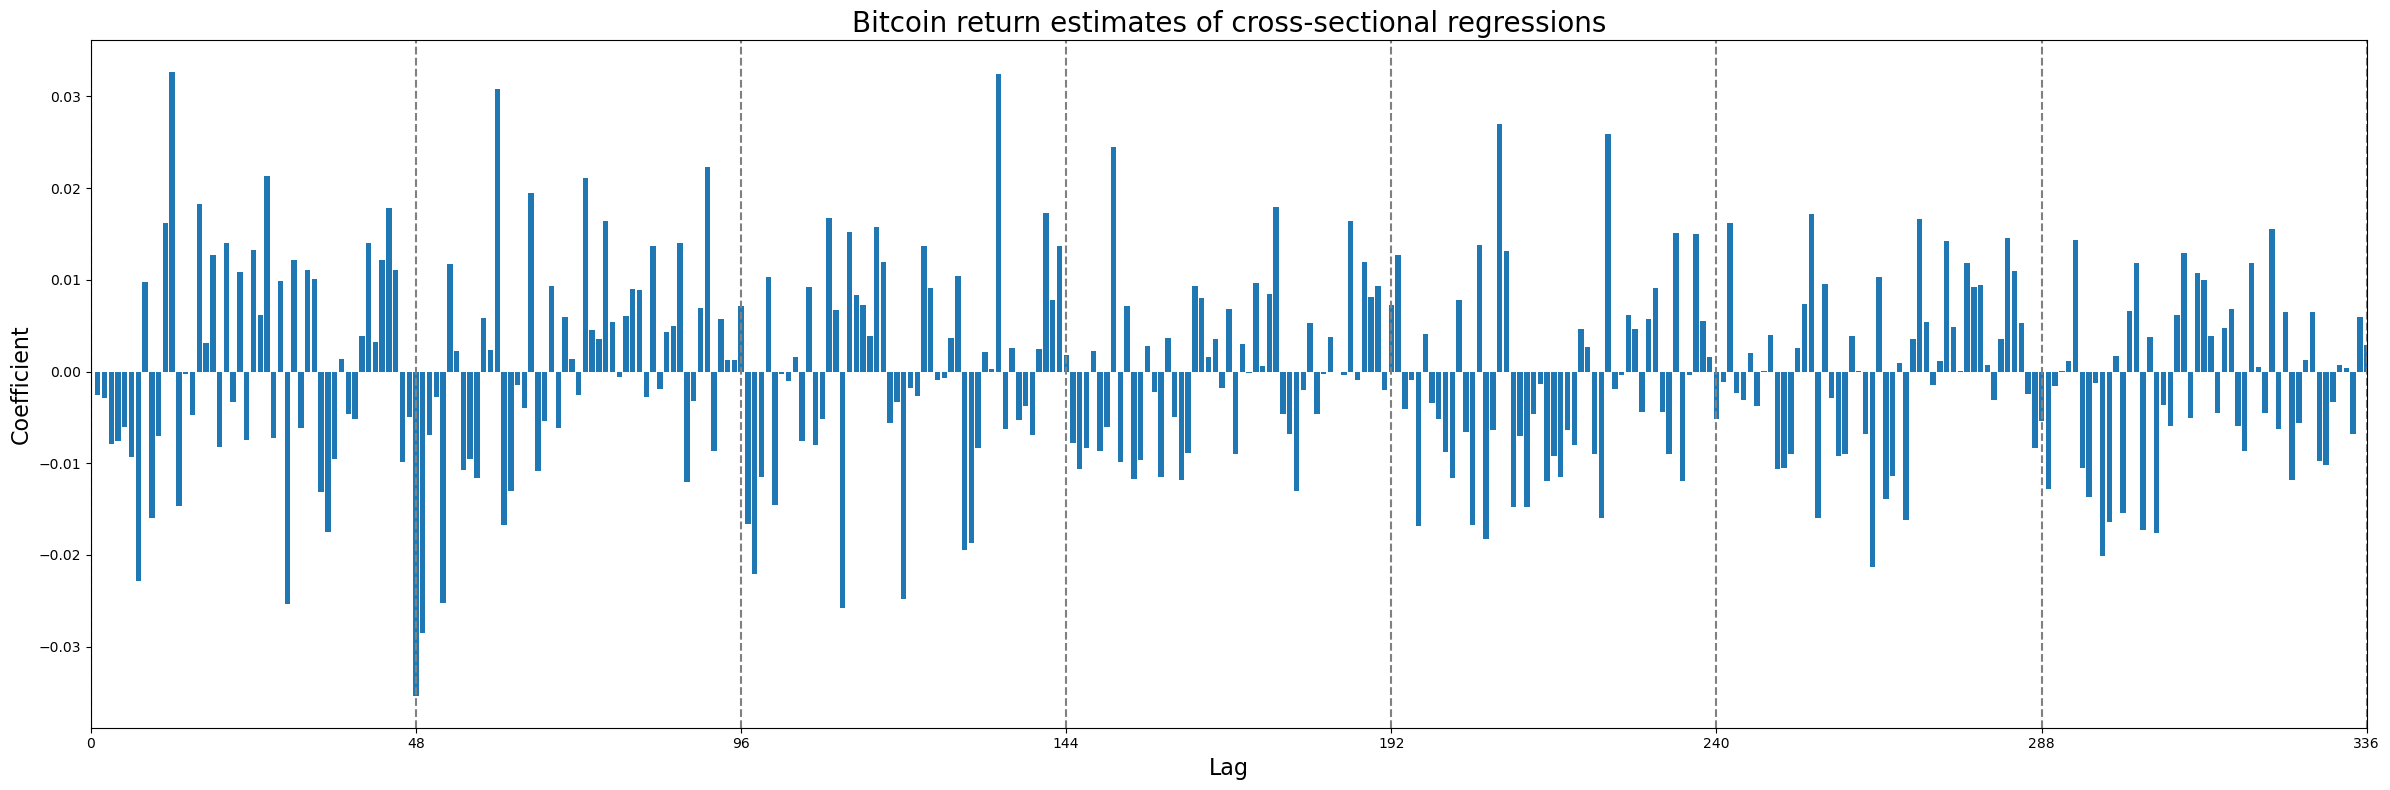

In [32]:
# Extract coefficients
coef_btc = BTC_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_btc.values, 0)
gamma = np.insert(np.array(gamma), 0, 0)
# Get x-axis lags number
lags = np.delete(coef_btc.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# To plot only lag a week data
lags = lags[:337]
gamma = gamma[:337]
# Create a bar plot
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient', fontsize=16)
ax.set_xlabel('Lag', fontsize=16)
# set the x ticks and limit
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Bitcoin return estimates of cross-sectional regressions', fontsize=20)
fig.tight_layout()
plt.show()
fig.savefig('output/btc_estmates_336.jpg')

Plot Bitcoin return t-statistics of cross-sectional regression estimates

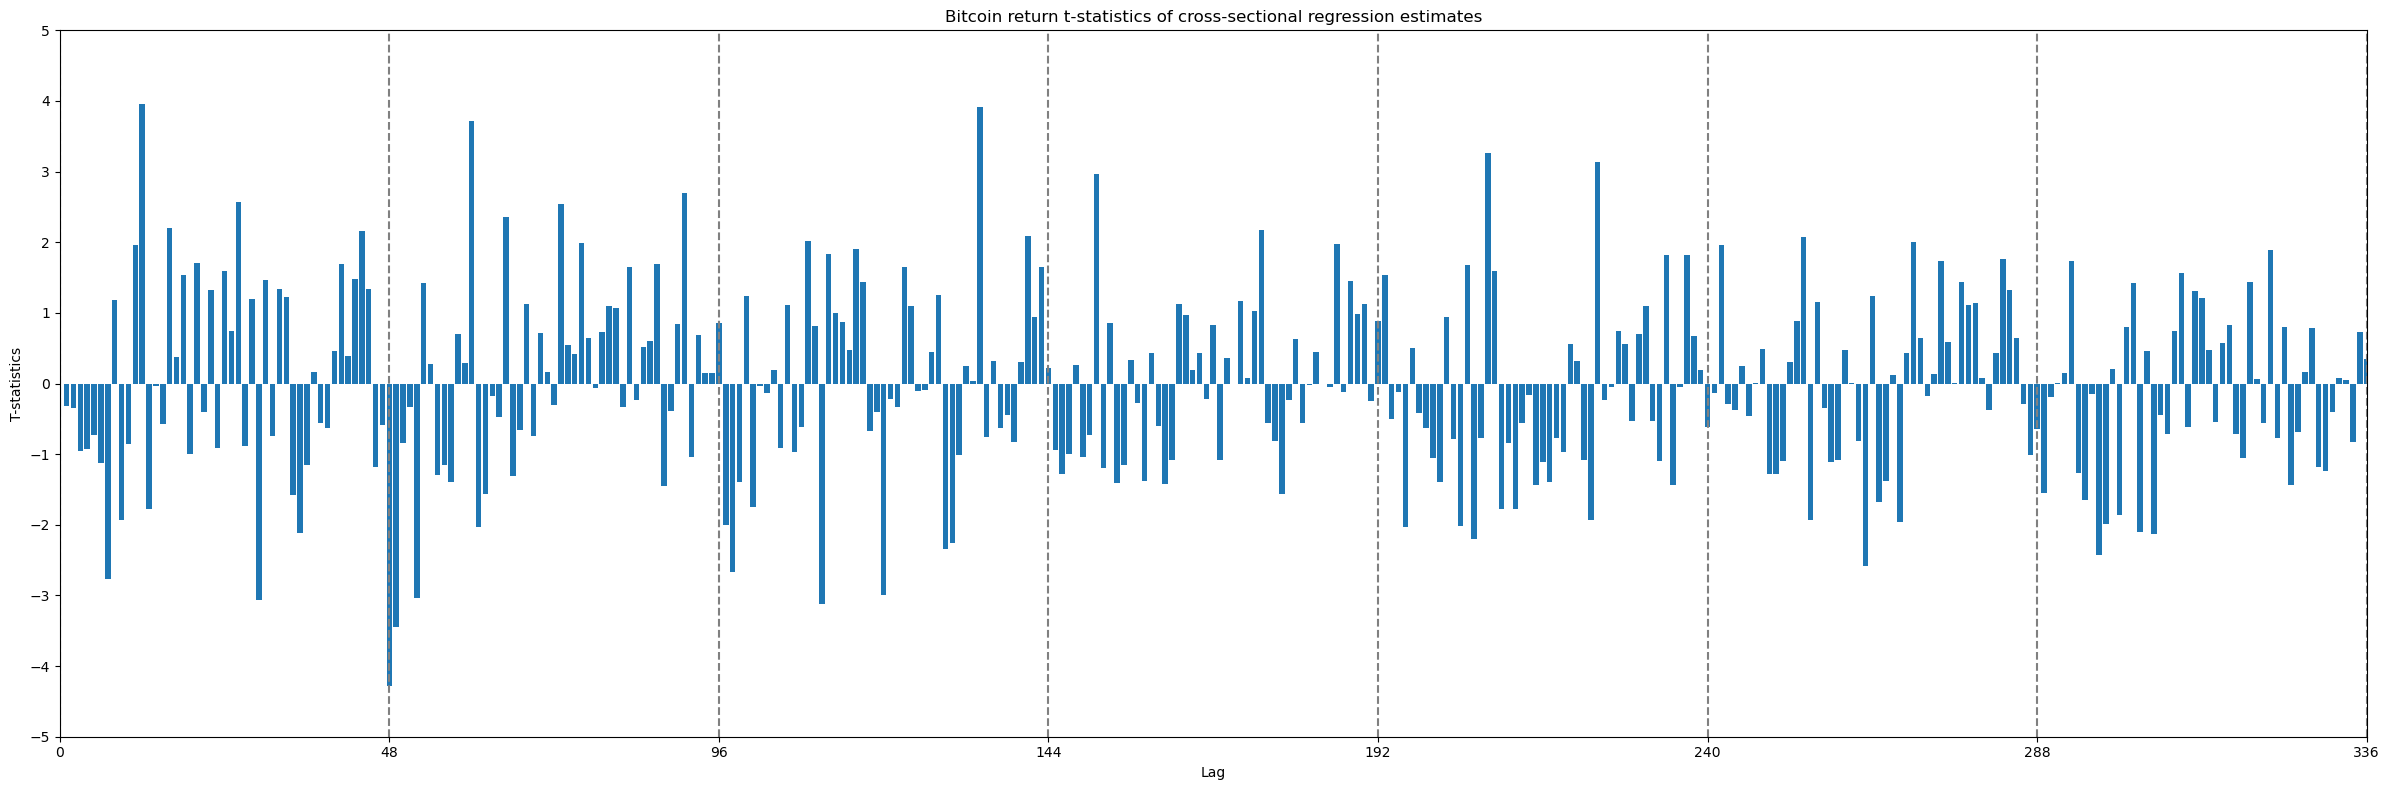

In [34]:
# Extract t-statistic values
tvalue_btc = BTC_lag1440_ret_reg.tvalues
tstats = np.array(tvalue_btc)
# Delete intercept coef
tstats = np.delete(tstats, 0)
tstats = np.insert(tstats, 0, 0)
lags = np.delete(coef_btc.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# To plot only lag a week data
lags = lags[:337]
tstats = tstats[:337]
# Create a bar plot
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, tstats)
ax.set_ylabel('T-statistics')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-5, 8)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_yticks([i for i in range(-5, 6)])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Bitcoin return t-statistics of cross-sectional regression estimates')
fig.tight_layout()
plt.show()
fig.savefig('output/btc_tvalue_336.jpg')

#### Run regression for other cryptos
#### Code are some as doing with Bitcoin

#### ETH

In [35]:
# shift k lags
df_returns['ETH_ret_lag1'] = df_returns['ETH_return'].shift()
df_eth_ret = df_returns[['ETH_return', 'ETH_ret_lag1']]
df_eth_ret.rename(columns={'ETH_return': 'ETH_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "ETH_ret_lag" + str(i)
    df_eth_ret[lag] = df_returns['ETH_return'].shift(i)

In [36]:
# reverse dataset for better understandding of lags
df_eth_ret_r = df_eth_ret.iloc[::-1]
# remove missing data
df_eth_ret_r = df_eth_ret_r.dropna()

In [37]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_eth_ret_r.columns)
y = df_eth_ret_r[lag_cols.pop(0)]
X = df_eth_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
ETH_lag1440_ret_reg = sm.OLS(y, X).fit()

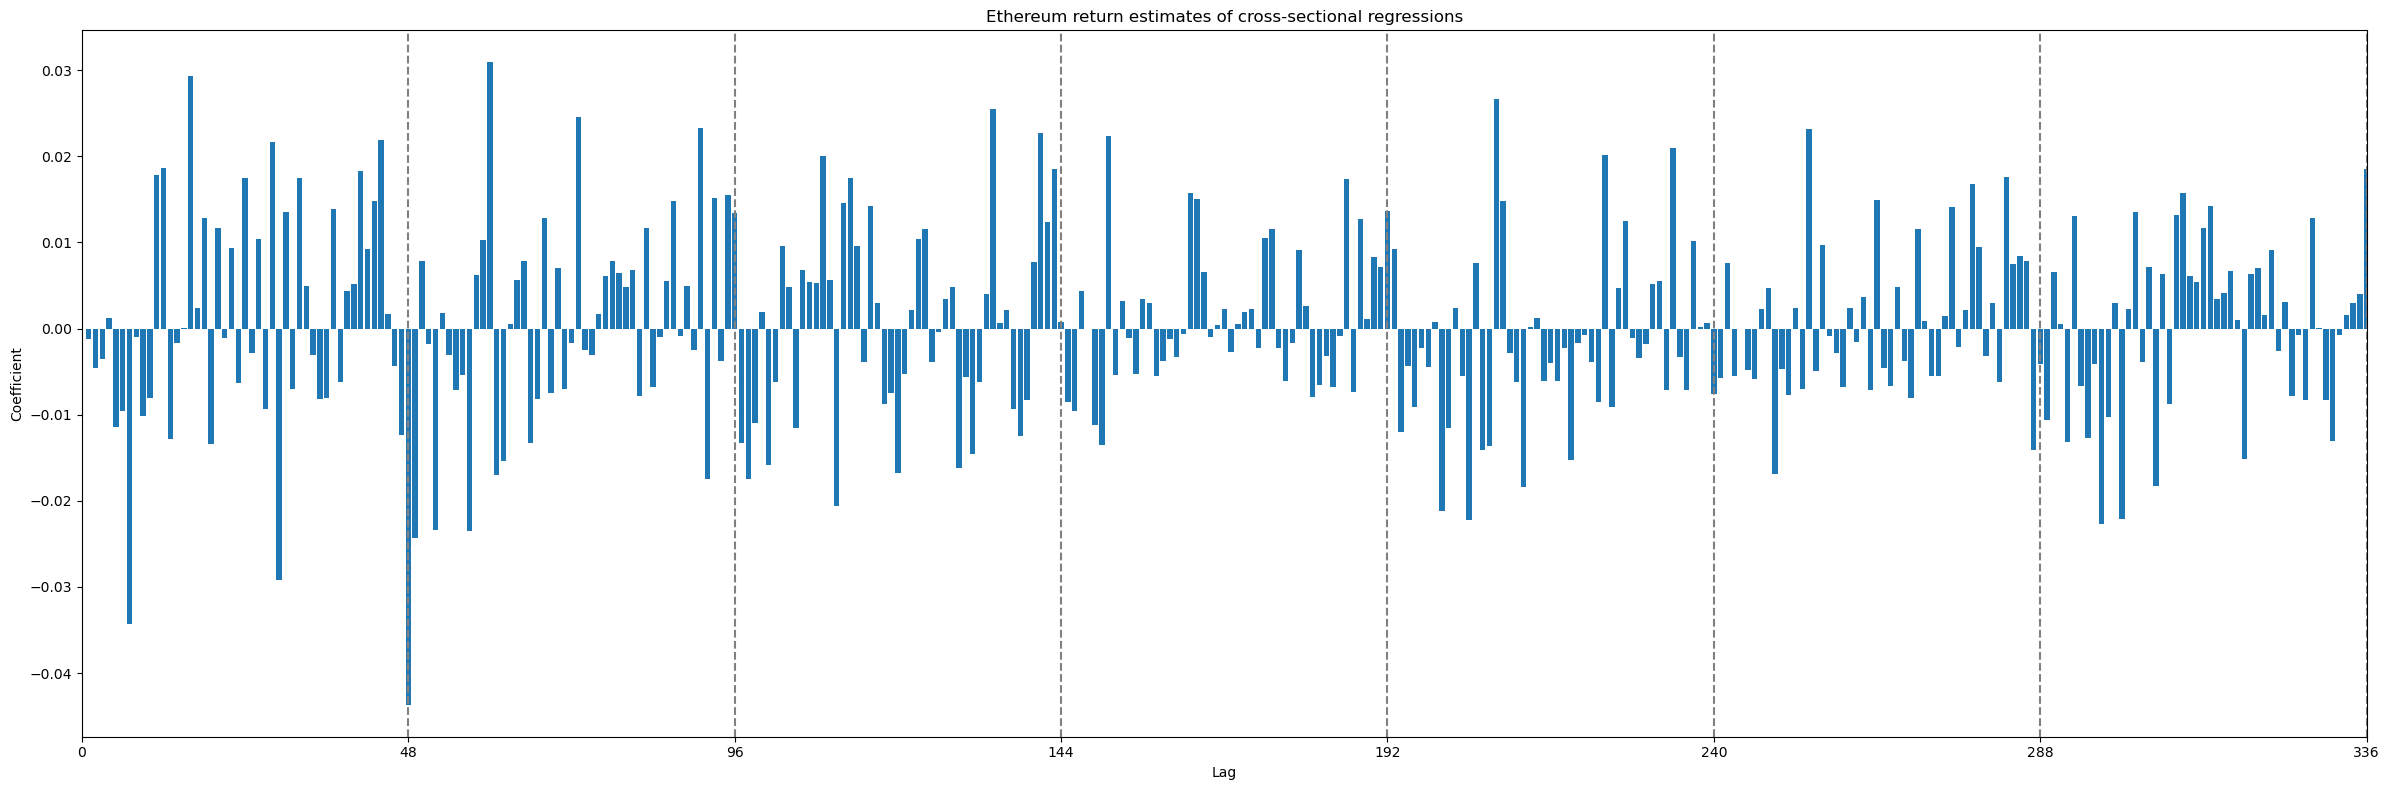

In [38]:
# Extract coefficients
coef_eth = ETH_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_eth.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_eth.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
# To plot only lag a week data
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Ethereum return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [39]:
# store t-stat for later use
tvalue_eth = ETH_lag1440_ret_reg.tvalues

#### DOGE

In [40]:
# shift k lags
df_returns['DOGE_ret_lag1'] = df_returns['DOGE_return'].shift()
df_doge_ret = df_returns[['DOGE_return', 'DOGE_ret_lag1']]
df_doge_ret.rename(columns={'DOGE_return': 'DOGE_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "DOGE_ret_lag" + str(i)
    df_doge_ret[lag] = df_returns['DOGE_return'].shift(i)

In [41]:
# reverse dataset for better understandding of lags
df_doge_ret_r = df_doge_ret.iloc[::-1]
# remove missing data
df_doge_ret_r = df_doge_ret_r.dropna()

In [42]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_doge_ret_r.columns)
y = df_doge_ret_r[lag_cols.pop(0)]
X = df_doge_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
DOGE_lag1440_ret_reg = sm.OLS(y, X).fit()

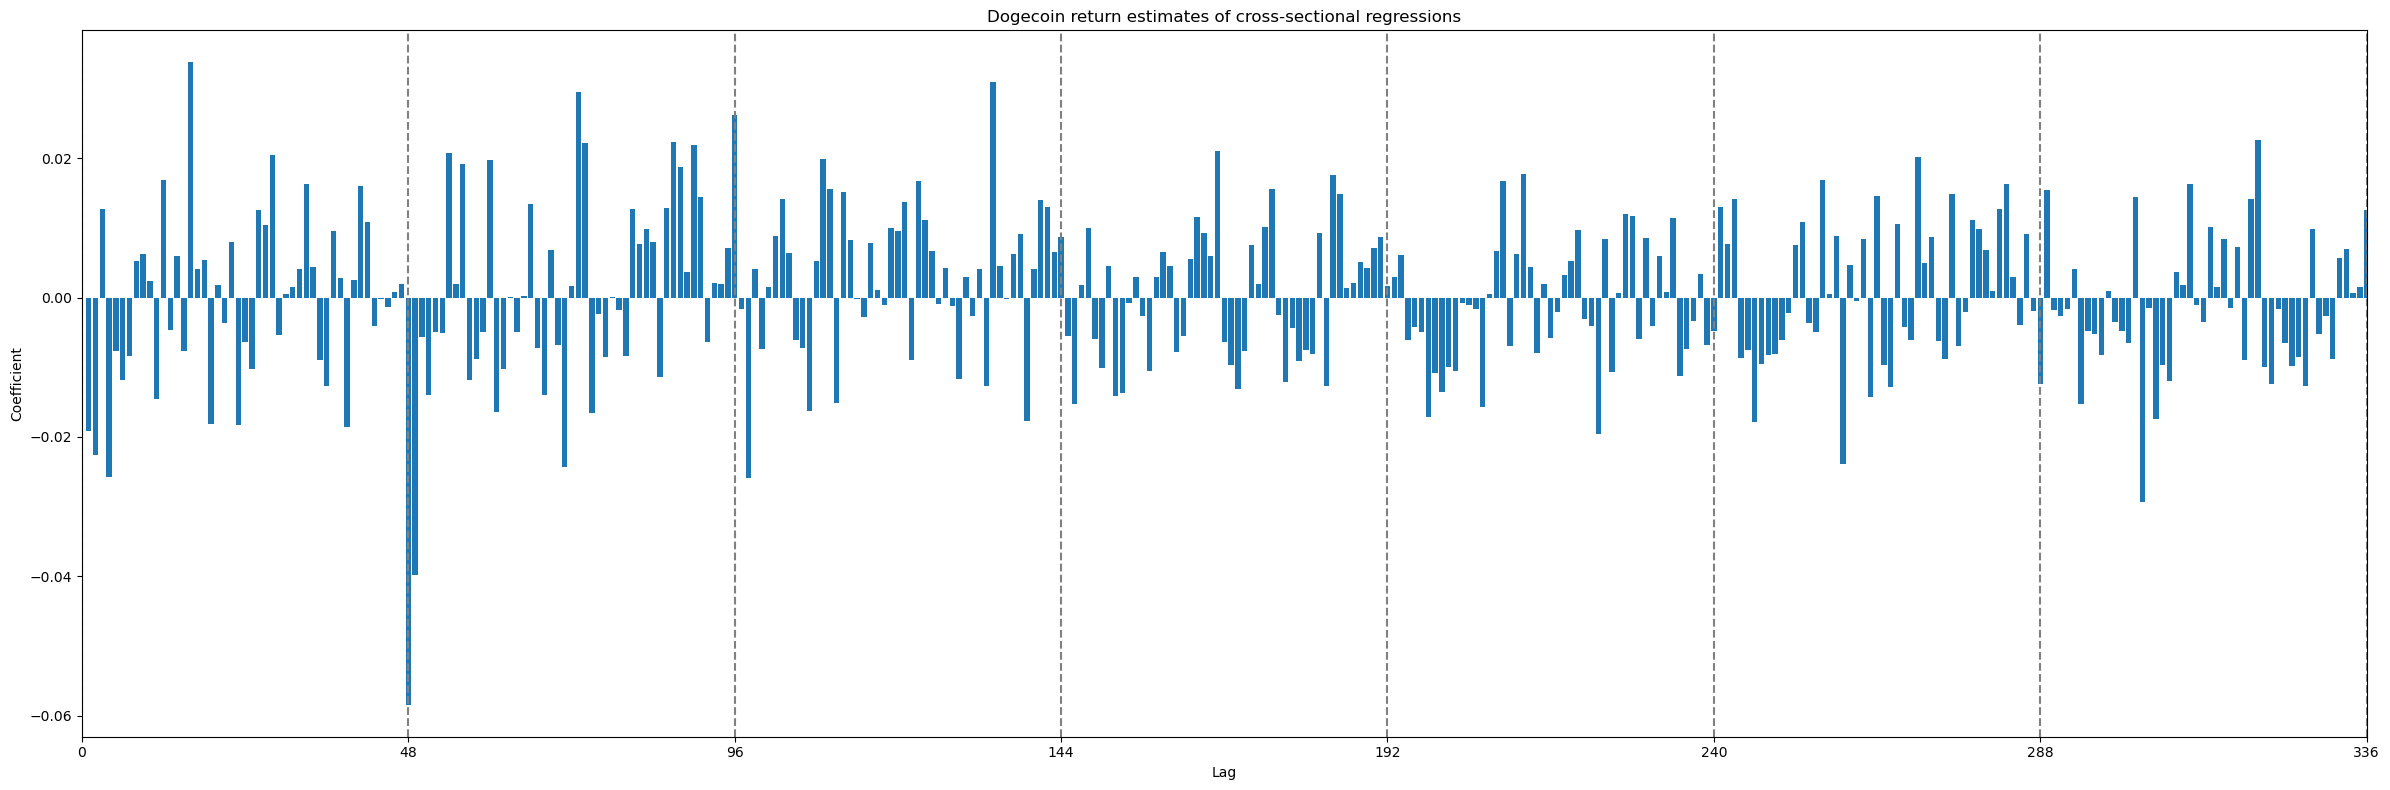

In [43]:
# Extract coefficients
coef_doge = DOGE_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_doge.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_doge.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
# To plot only lag a week data
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Dogecoin return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [44]:
# store t-stat for later use
tvalue_doge = DOGE_lag1440_ret_reg.tvalues

#### SOL

In [45]:
# shift k lags
df_returns['SOL_ret_lag1'] = df_returns['SOL_return'].shift()
df_sol_ret = df_returns[['SOL_return', 'SOL_ret_lag1']]
df_sol_ret.rename(columns={'SOL_return': 'SOL_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "SOL_ret_lag" + str(i)
    df_sol_ret[lag] = df_returns['SOL_return'].shift(i)

In [46]:
# reverse dataset for better understandding of lags
df_sol_ret_r = df_sol_ret.iloc[::-1]
# remove missing data
df_sol_ret_r = df_sol_ret_r.dropna()

In [47]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_sol_ret_r.columns)
y = df_sol_ret_r[lag_cols.pop(0)]
X = df_sol_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
SOL_lag1440_ret_reg = sm.OLS(y, X).fit()

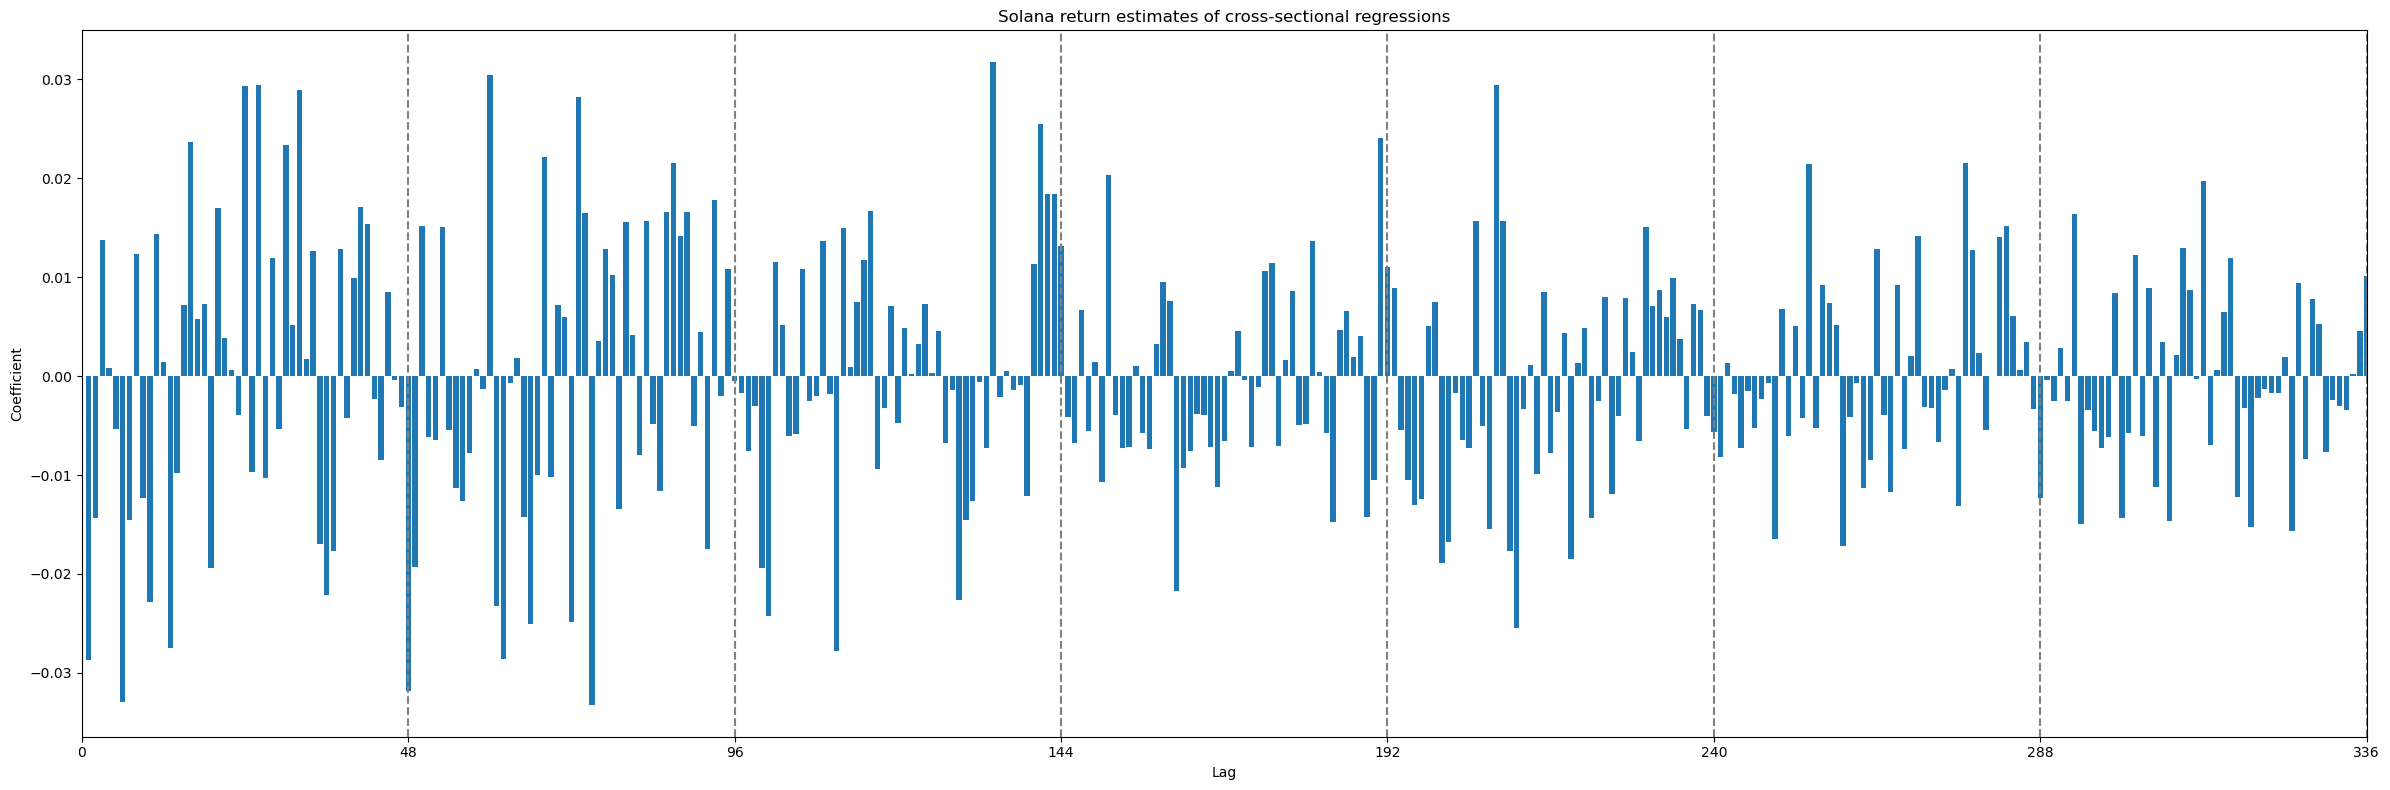

In [48]:
# Extract coefficients
coef_sol = SOL_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_sol.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_sol.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
# To plot only lag a week data
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Solana return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [49]:
# store t-stat for later use
tvalue_sol = SOL_lag1440_ret_reg.tvalues

#### FIL

In [50]:
# shift k lags
df_returns['FIL_ret_lag1'] = df_returns['FIL_return'].shift()
df_fil_ret = df_returns[['FIL_return', 'FIL_ret_lag1']]
df_fil_ret.rename(columns={'FIL_return': 'FIL_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "FIL_ret_lag" + str(i)
    df_fil_ret[lag] = df_returns['FIL_return'].shift(i)

In [51]:
# reverse dataset for better understandding of lags
df_fil_ret_r = df_fil_ret.iloc[::-1]
# remove missing data
df_fil_ret_r = df_fil_ret_r.dropna()

In [52]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_fil_ret_r.columns)
y = df_fil_ret_r[lag_cols.pop(0)]
X = df_fil_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
FIL_lag1440_ret_reg = sm.OLS(y, X).fit()

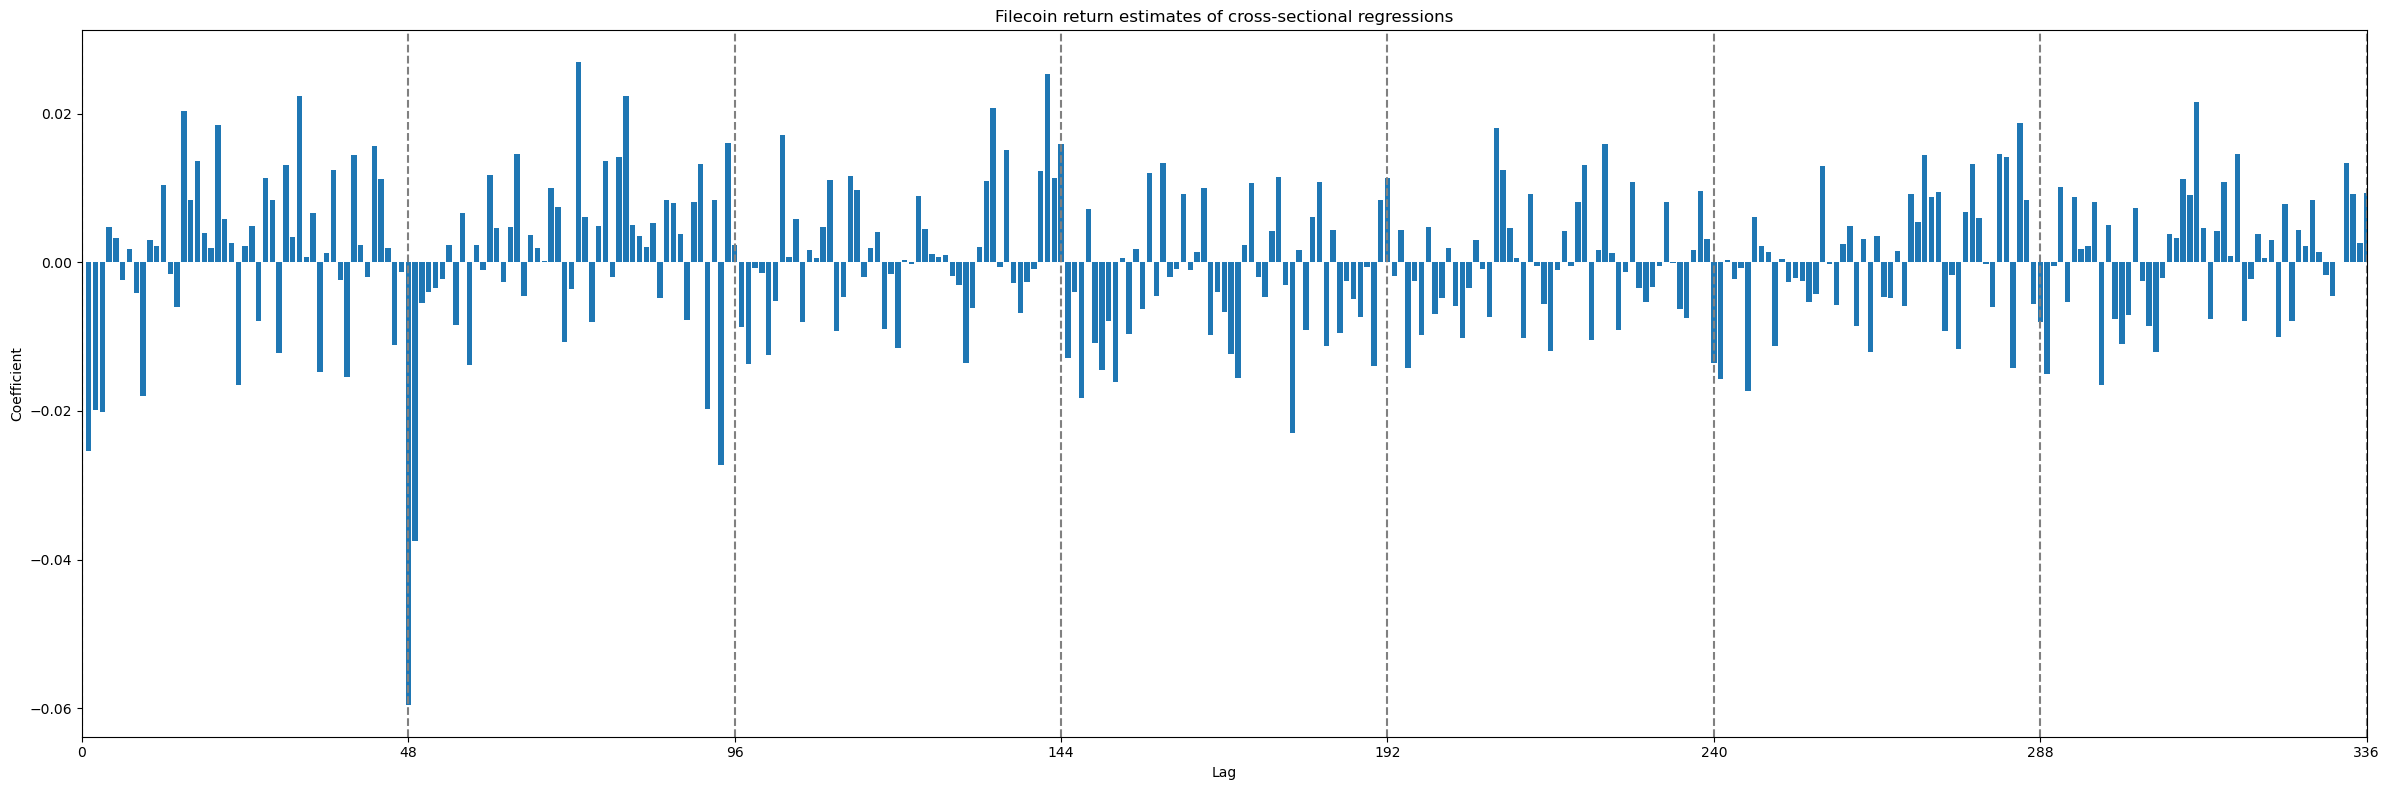

In [53]:
# Extract coefficients
coef_fil = FIL_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_fil.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_fil.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
# To plot only lag a week data
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Filecoin return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [54]:
# store t-stat for later use
tvalue_fil = FIL_lag1440_ret_reg.tvalues

#### LTC

In [55]:
# shift k lags
df_returns['LTC_ret_lag1'] = df_returns['LTC_return'].shift()
df_ltc_ret = df_returns[['LTC_return', 'LTC_ret_lag1']]
df_ltc_ret.rename(columns={'LTC_return': 'LTC_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "LTC_ret_lag" + str(i)
    df_ltc_ret[lag] = df_returns['LTC_return'].shift(i)

In [56]:
# reverse dataset for better understandding of lags
df_ltc_ret_r = df_ltc_ret.iloc[::-1]
# remove missing data
df_ltc_ret_r = df_ltc_ret_r.dropna()

In [57]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_ltc_ret_r.columns)
y = df_ltc_ret_r[lag_cols.pop(0)]
X = df_ltc_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
LTC_lag1440_ret_reg = sm.OLS(y, X).fit()

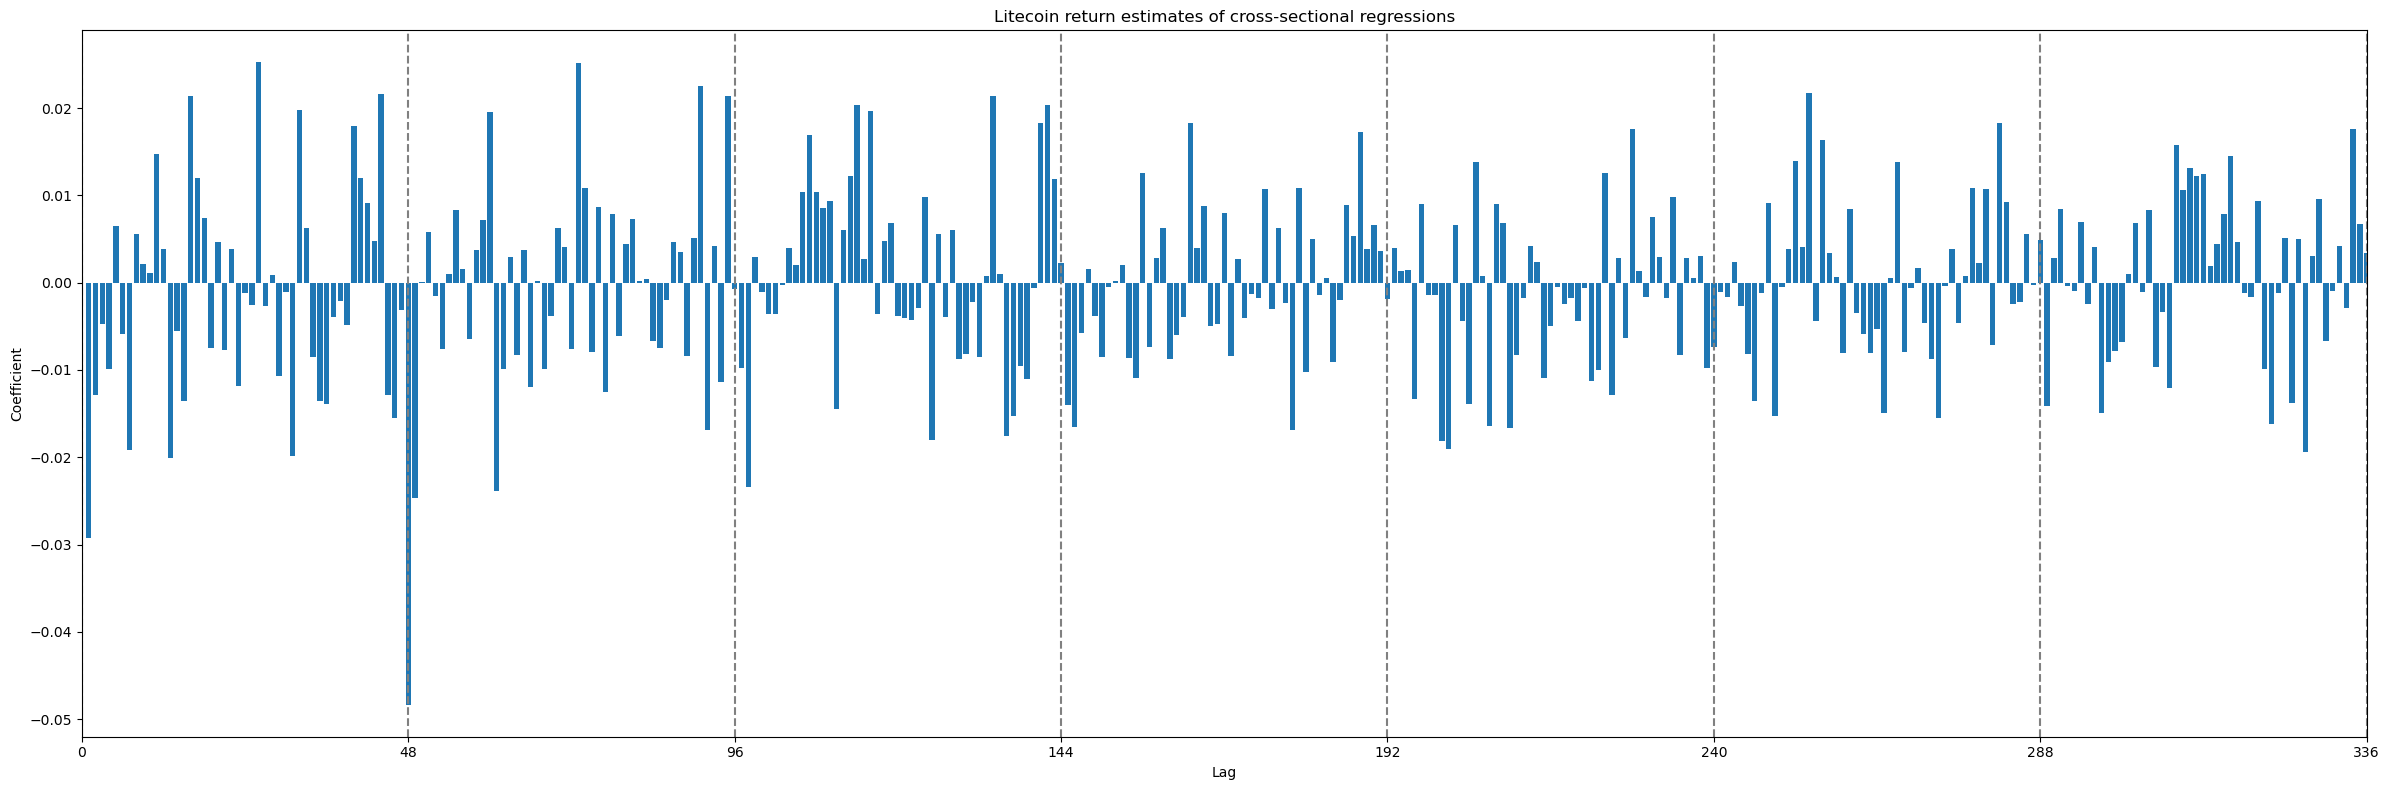

In [58]:
# Extract coefficients
coef_ltc = LTC_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_ltc.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_ltc.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
# To plot only lag a week data
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.5, 0.5)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Litecoin return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [59]:
# store t-stat for later use
tvalue_ltc = LTC_lag1440_ret_reg.tvalues

#### SHIB

In [60]:
# shift k lags
df_returns['SHIB_ret_lag1'] = df_returns['SHIB_return'].shift()
df_shib_ret = df_returns[['SHIB_return', 'SHIB_ret_lag1']]
df_shib_ret.rename(columns={'SHIB_return': 'SHIB_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "SHIB_ret_lag" + str(i)
    df_shib_ret[lag] = df_returns['SHIB_return'].shift(i)

In [61]:
# # This is the approach to run regression for all data
# cols = list(df_shib_ret.columns)
# formula = cols[0] + '~' + cols[1]
# for i in range(2, len(cols)):
#     formula += '+' + cols[i]
#     if i == 480:
#         break
# reg = smf.ols(formula=formula, data=df_shib_ret).fit()

In [62]:
# reverse dataset for better understandding of lags
df_shib_ret_r = df_shib_ret.iloc[::-1]
# remove missing data
df_shib_ret_r = df_shib_ret_r.dropna()

In [63]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_shib_ret_r.columns)
y = df_shib_ret_r[lag_cols.pop(0)]
X = df_shib_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
SHIB_lag1440_ret_reg = sm.OLS(y, X).fit()

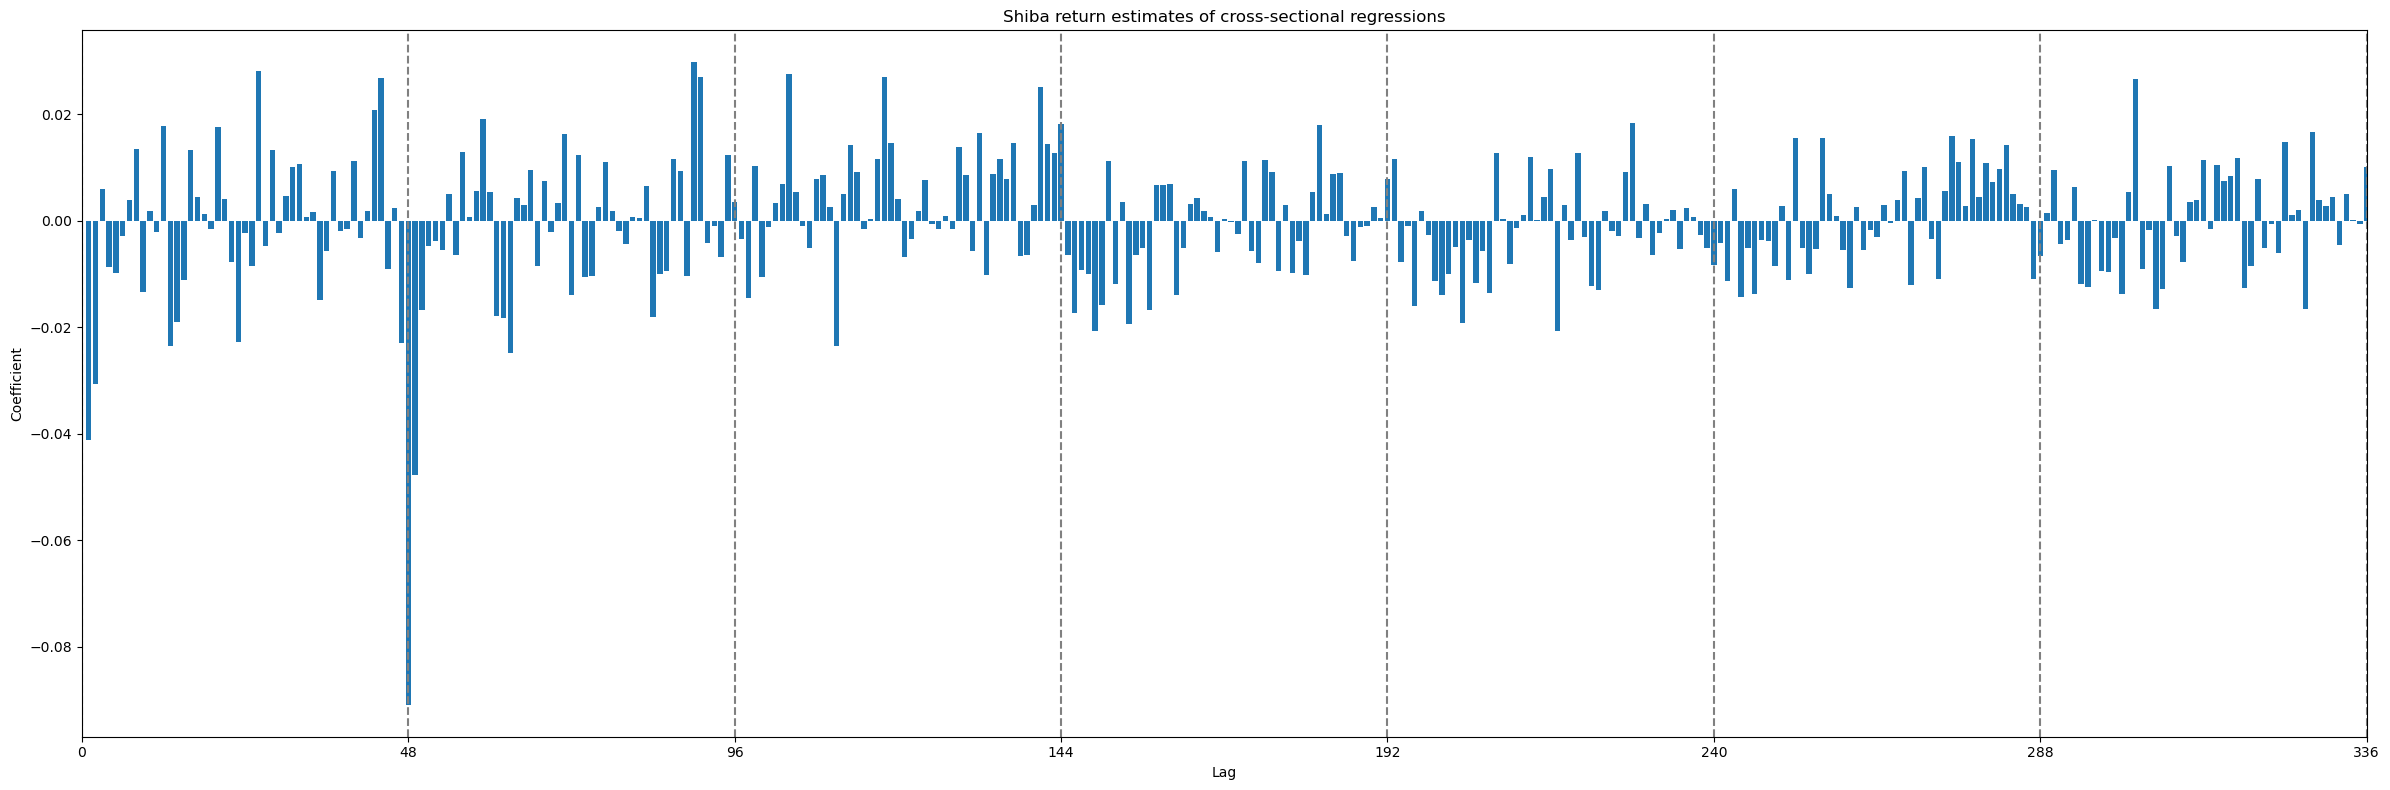

In [64]:
# Extract coefficients
coef_shib = SHIB_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_shib.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_shib.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
# To plot only lag a week data
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.5, 0.5)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Shiba return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [65]:
# store t-stat for later use
tvalue_shib = SHIB_lag1440_ret_reg.tvalues

#### BNB

In [66]:
# shift k lags
df_returns['BNB_ret_lag1'] = df_returns['BNB_return'].shift()
df_bnb_ret = df_returns[['BNB_return', 'BNB_ret_lag1']]
df_bnb_ret.rename(columns={'BNB_return': 'BNB_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "BNB_ret_lag" + str(i)
    df_bnb_ret[lag] = df_returns['BNB_return'].shift(i)

In [67]:
# reverse dataset for better understandding of lags
df_bnb_ret_r = df_bnb_ret.iloc[::-1]
# remove missing data
df_bnb_ret_r = df_bnb_ret_r.dropna()

In [68]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_bnb_ret_r.columns)
y = df_bnb_ret_r[lag_cols.pop(0)]
X = df_bnb_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
BNB_lag1440_ret_reg = sm.OLS(y, X).fit()

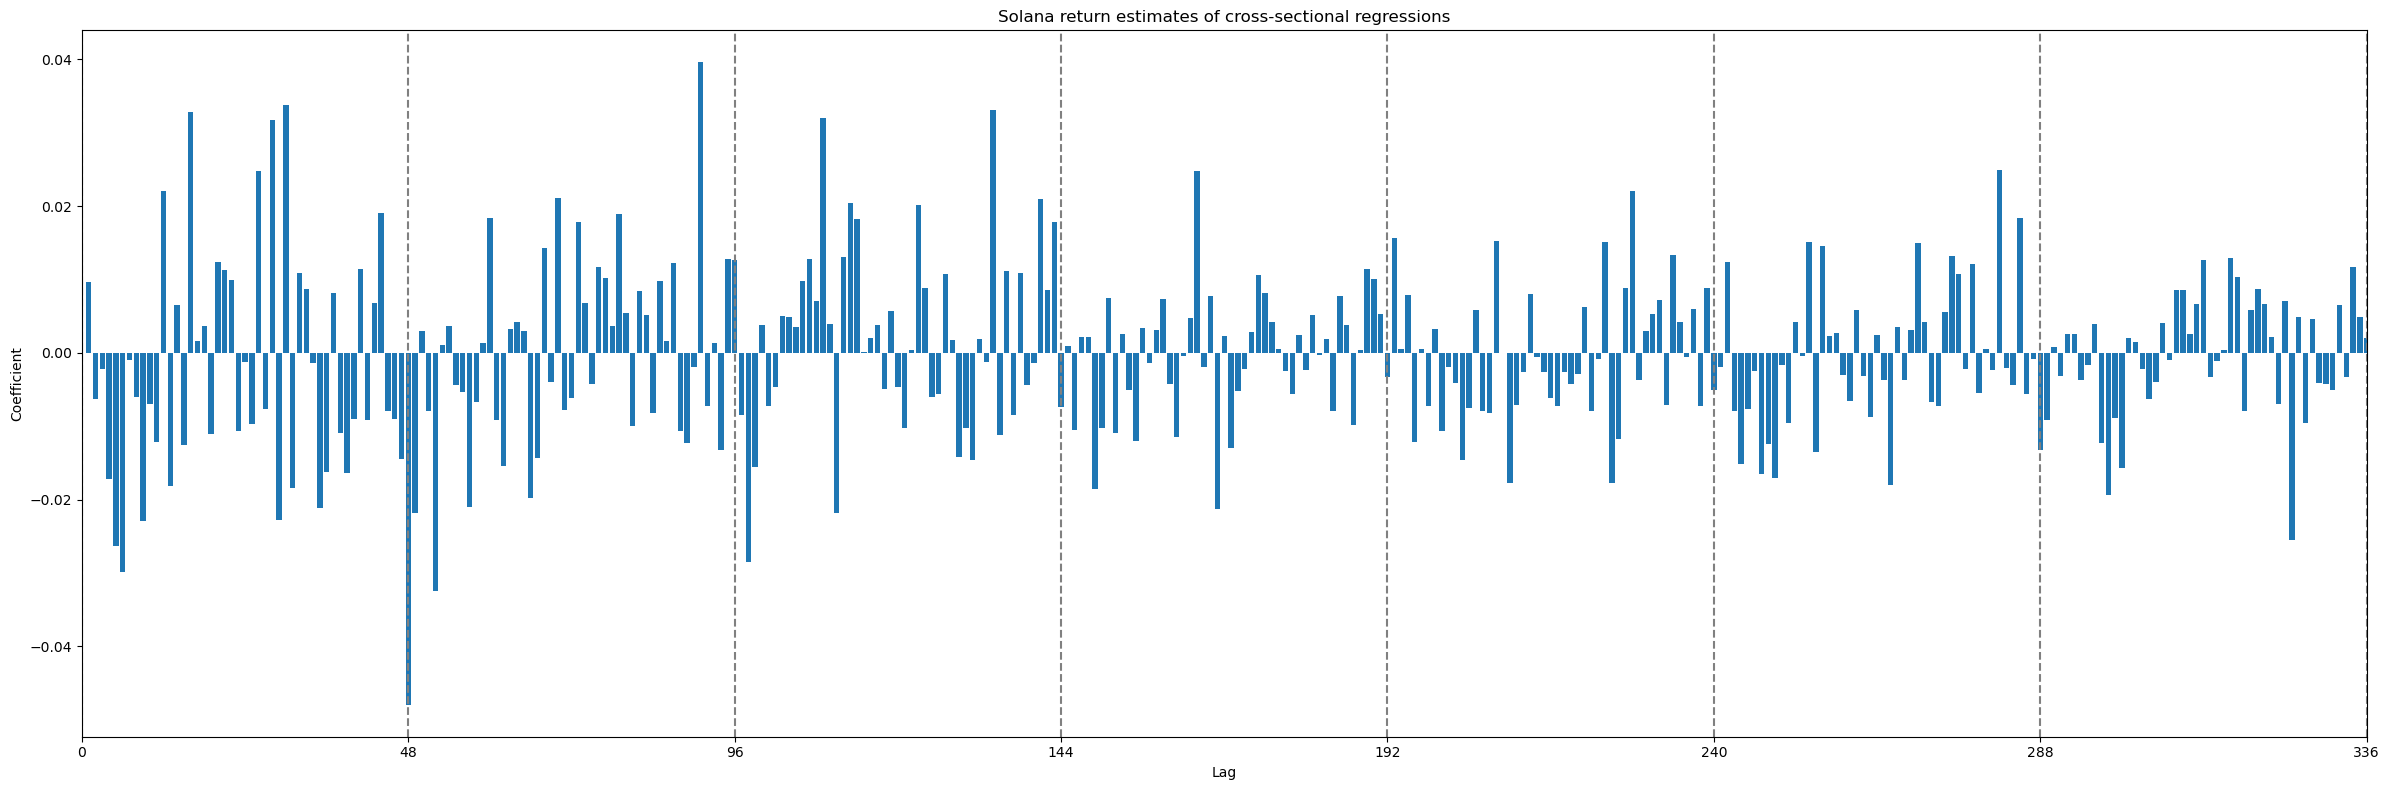

In [69]:
# Extract coefficients
coef_bnb = BNB_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_bnb.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_bnb.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
# To plot only lag a week data
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Solana return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [70]:
# store t-stat for later use
tvalue_bnb = BNB_lag1440_ret_reg.tvalues

#### XRP

In [71]:
# shift k lags
df_returns['XRP_ret_lag1'] = df_returns['XRP_return'].shift()
df_xrp_ret = df_returns[['XRP_return', 'XRP_ret_lag1']]
df_xrp_ret.rename(columns={'XRP_return': 'XRP_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "XRP_ret_lag" + str(i)
    df_xrp_ret[lag] = df_returns['XRP_return'].shift(i)

In [72]:
# reverse dataset for better understandding of lags
df_xrp_ret_r = df_xrp_ret.iloc[::-1]
# remove missing data
df_xrp_ret_r = df_xrp_ret_r.dropna()

In [73]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_xrp_ret_r.columns)
y = df_xrp_ret_r[lag_cols.pop(0)]
X = df_xrp_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
XRP_lag1440_ret_reg = sm.OLS(y, X).fit()

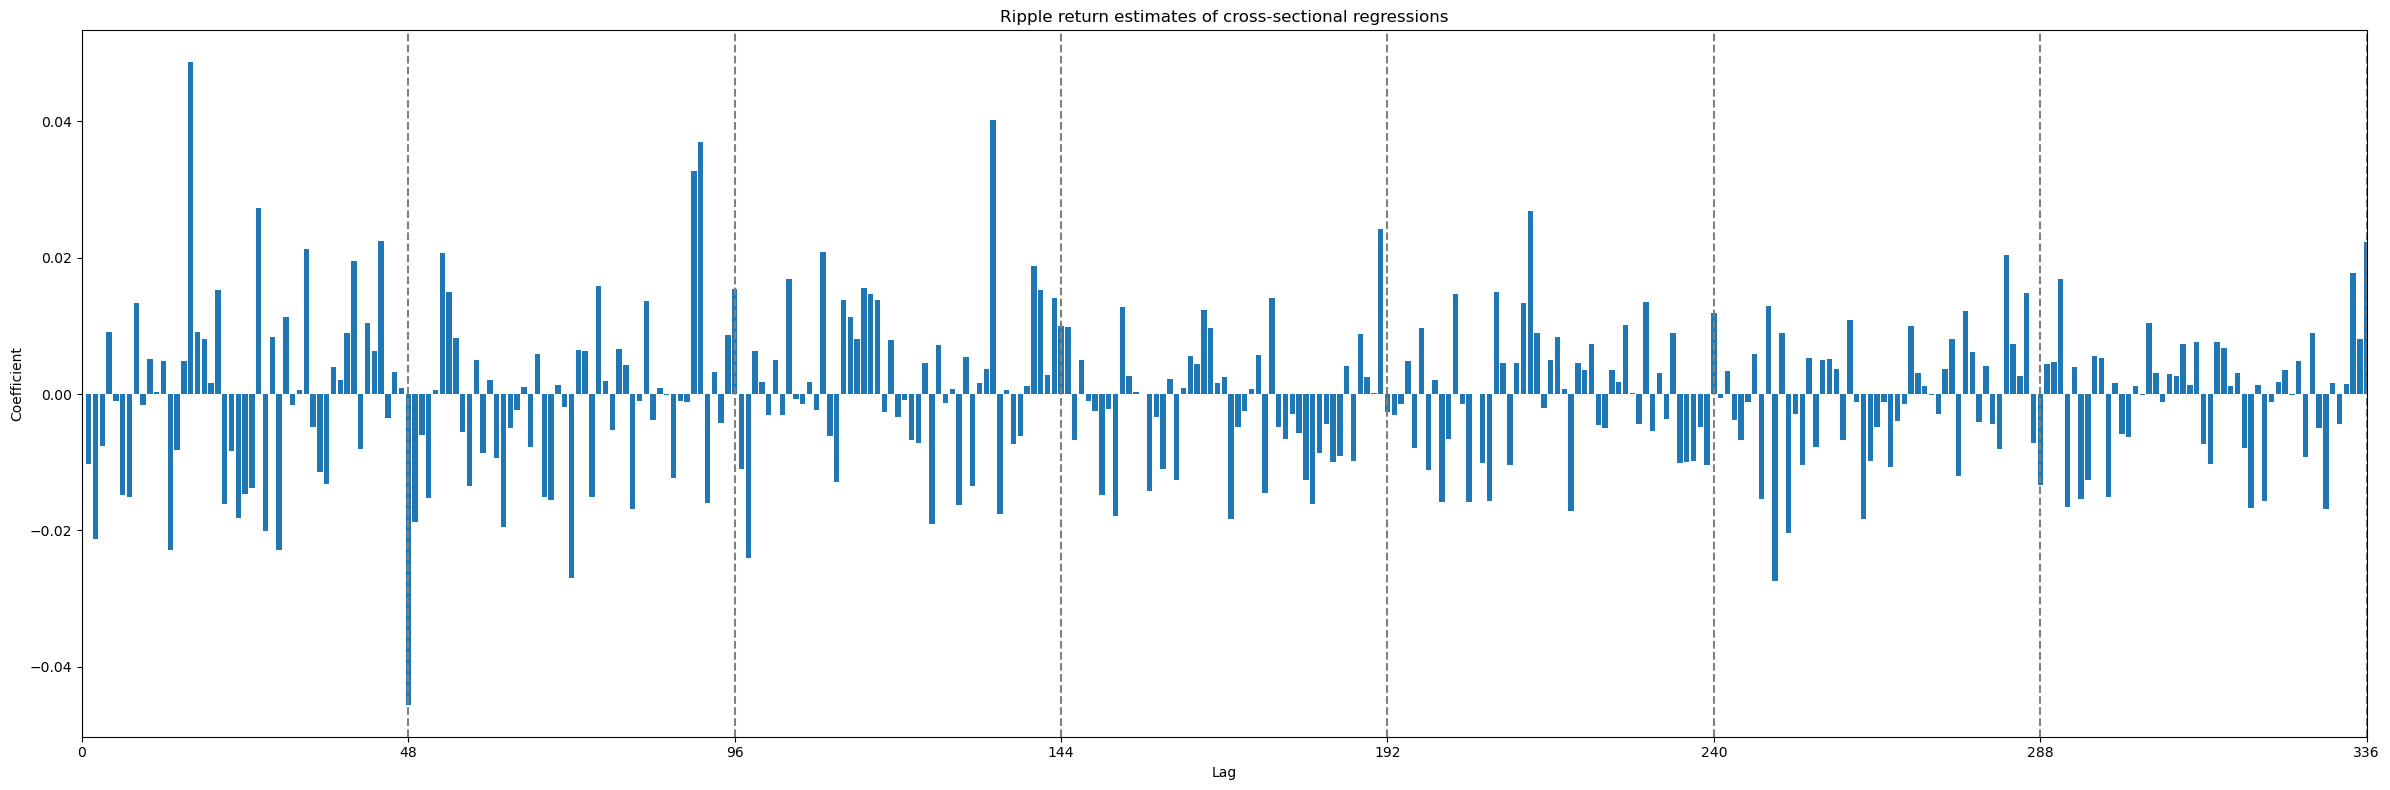

In [74]:
# Extract coefficients
coef_xrp = XRP_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_xrp.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_xrp.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
# To plot only lag a week data
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.4)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Ripple return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [75]:
# store t-stat for later use
tvalue_xrp = XRP_lag1440_ret_reg.tvalues

#### AAVE

In [76]:
# shift k lags
df_returns['AAVE_ret_lag1'] = df_returns['AAVE_return'].shift()
df_aave_ret = df_returns[['AAVE_return', 'AAVE_ret_lag1']]
df_aave_ret.rename(columns={'AAVE_return': 'AAVE_ret_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "AAVE_ret_lag" + str(i)
    df_aave_ret[lag] = df_returns['AAVE_return'].shift(i)

In [77]:
# reverse dataset for better understandding of lags
df_aave_ret_r = df_aave_ret.iloc[::-1]
# remove missing data
df_aave_ret_r = df_aave_ret_r.dropna()

In [78]:
# Specify the dependent and independent variables
# dependent variable: lastest returns k = 0
# independent variables: lag returns k, k = 1 ... 1440
lag_cols = list(df_aave_ret_r.columns)
y = df_aave_ret_r[lag_cols.pop(0)]
X = df_aave_ret_r[lag_cols]
X = sm.add_constant(X) 
# Run the regression
AAVE_lag1440_ret_reg = sm.OLS(y, X).fit()

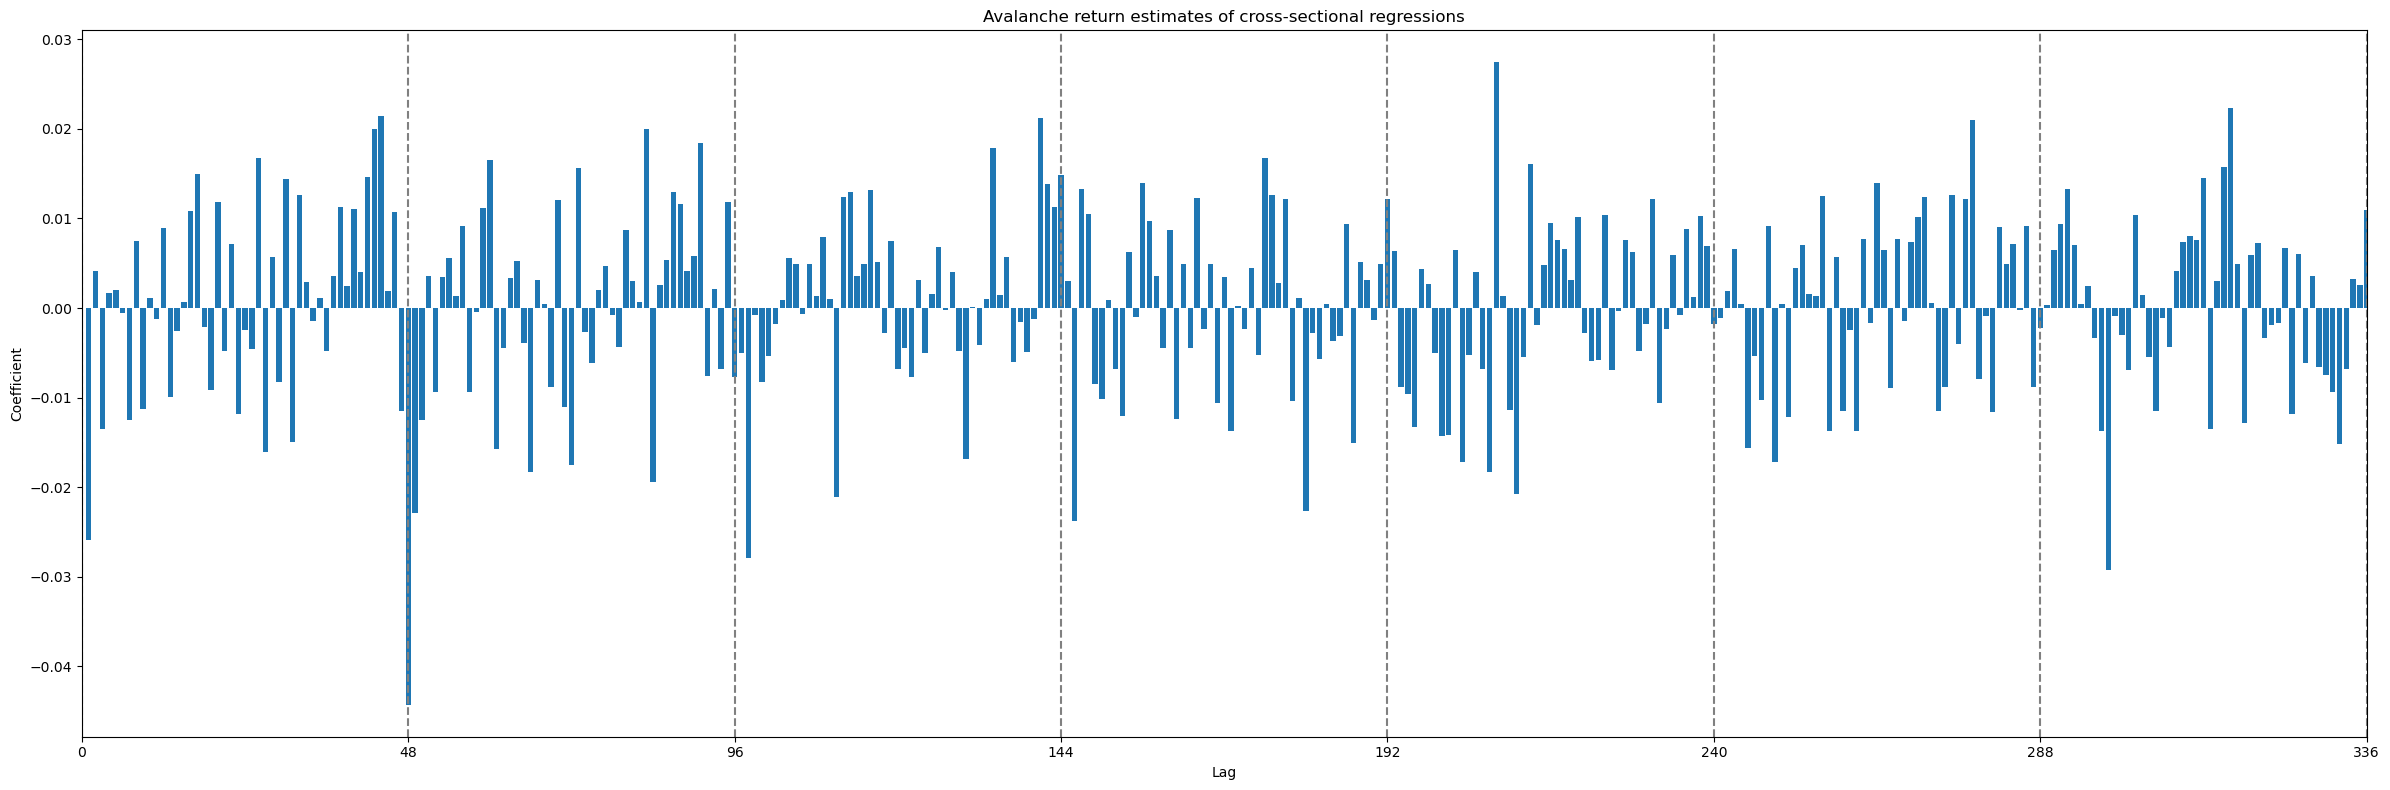

In [79]:
# Extract coefficients
coef_aave = AAVE_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_aave.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_aave.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
# To plot only lag a week data
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
# ax.set_ylim(-0.35, 0.3)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Avalanche return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [80]:
# store t-stat for later use
tvalue_aave = AAVE_lag1440_ret_reg.tvalues

#### Plot decile results of the 10 cryptos, make a portfolio and find the decile estimates and t-statistics

Find the estimates for the portfolio

In [81]:
# makeup a coefficient dataframe using data by previous stored coefficients
df_coef = pd.DataFrame()
cryptos = ['btc', 'eth', 'doge', 'sol', 'fil', 'ltc', 'bnb', 'shib', 'xrp', 'aave']
for c in cryptos:
    coef = globals().get(f"coef_{c}")
    temp = pd.DataFrame(coef[1:]).transpose()
    replace = c.upper() + '_'
    temp = temp.rename(columns=lambda x: x.replace(replace, '') if replace in x else x)
    df_coef = pd.concat([df_coef, temp])

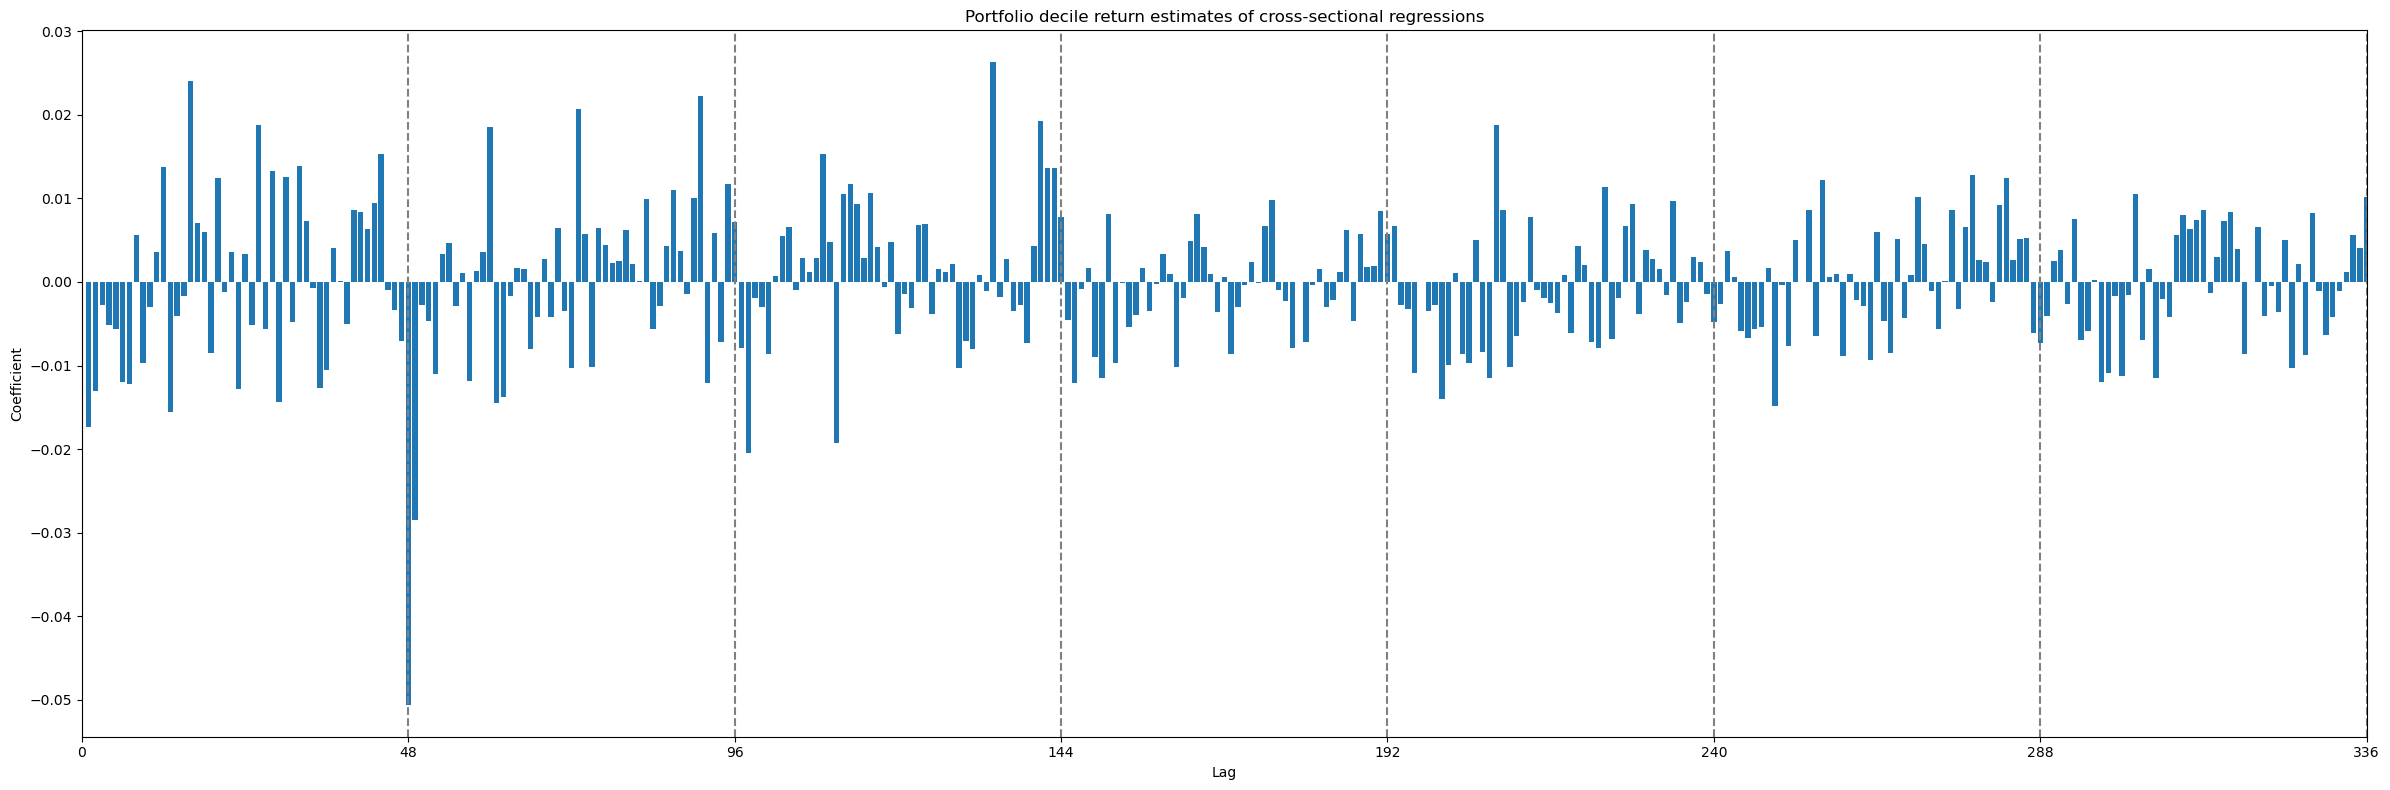

In [82]:
lags = list(df_coef.columns)
gamma = np.array(df_coef.mean())
gamma = np.insert(gamma, 0, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# plot only lag 1 week data
lags = lags[:337]
gamma = gamma[:337]
# Create a bar plot
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the x ticks and limit
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Portfolio decile return estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()
fig.savefig('output/portfolio_estimate_336.jpg')

Now, find the t-statistic for the portfolio

In [83]:
# makeup a t-value dataframe using data by previous stored t-values
df_tvalue = pd.DataFrame()
cryptos = ['btc', 'eth', 'doge', 'sol', 'fil', 'ltc', 'bnb', 'shib', 'xrp', 'aave']
for c in cryptos:
    tvalue = globals().get(f"tvalue_{c}")
    temp = pd.DataFrame(tvalue[1:]).transpose()
    replace = c.upper() + '_'
    temp = temp.rename(columns=lambda x: x.replace(replace, '') if replace in x else x)
    df_tvalue = pd.concat([df_tvalue, temp])

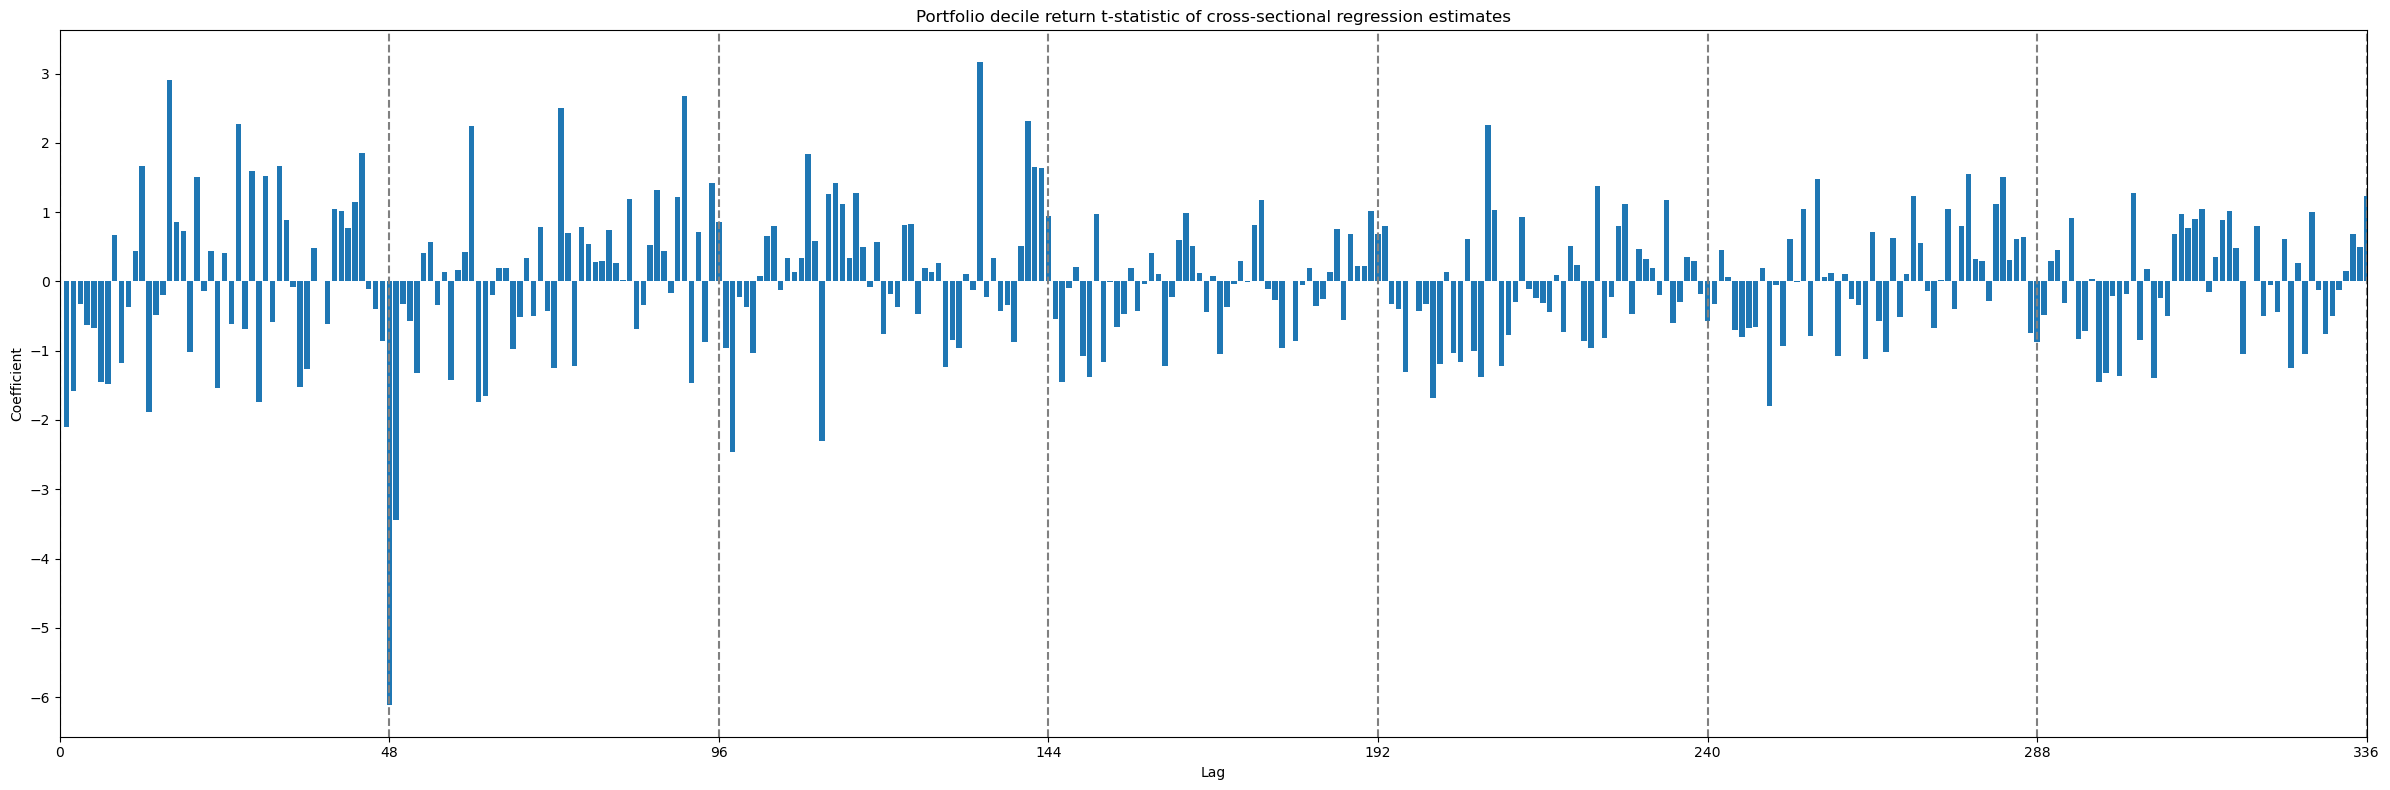

In [84]:
lags = list(df_tvalue.columns)
gamma = np.array(df_tvalue.mean())
gamma = np.insert(gamma, 0, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# plot only lag 1 week data
lags = lags[:337]
gamma = gamma[:337]
# Create a bar plot
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the x ticks and limit
ax.set_xticks(lags[::48])
ax.set_yticks([i for i in range(-6, 4)])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Portfolio decile return t-statistic of cross-sectional regression estimates')
fig.tight_layout()
plt.show()
fig.savefig('output/portfolio_tvalue_336.jpg')

#### Try to find 1 day estimates and t-statistics

Do it for Bitcoin first

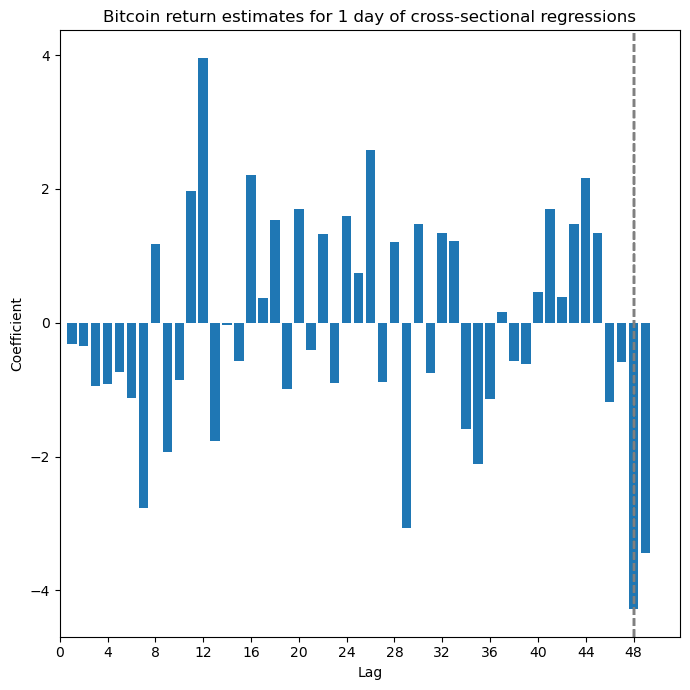

In [85]:
# Plot the 1 day coefficients for Bitcoin
# Extract coefficients
coef_btc = BTC_lag1440_ret_reg.params
# Delete intercept coef
gamma = np.delete(coef_btc.values, 0)
gamma = np.insert(np.array(gamma), 0, 0)
# Get x-axis lags number
lags = np.delete(coef_btc.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# To plot only lag a day data
lags = lags[:50]
gamma = tstats[:50]
# Create a bar plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the x ticks and limit
ax.set_xticks(lags[::4])
ax.set_xlim(lags.min())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=48, color='gray', linestyle='--')
ax.set_title('Bitcoin return estimates for 1 day of cross-sectional regressions')
fig.tight_layout()
plt.show()
fig.savefig('output/1day_estimate_for_btc.jpg')

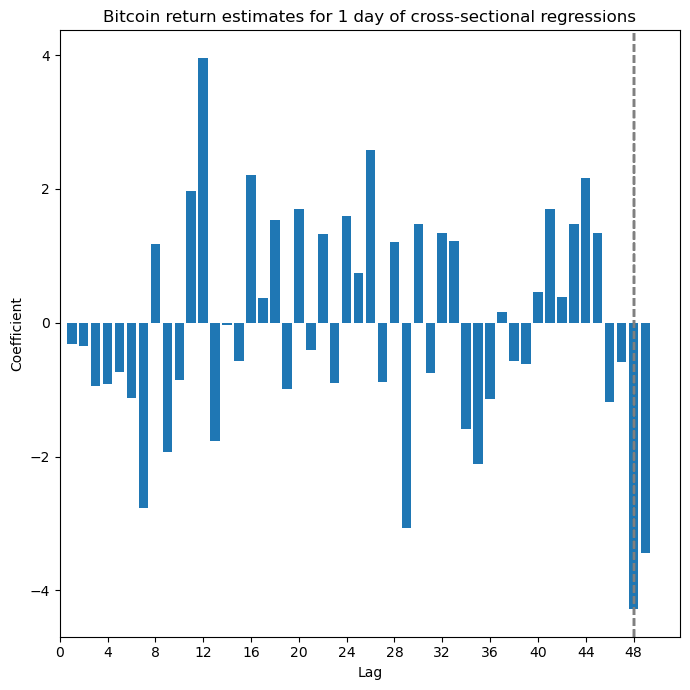

In [86]:
# Plot the 1 day t-values for Bitcoin
tstats = np.array(tvalue_btc)
# Delete intercept coef
tstats = np.delete(tstats, 0)
tstats = np.insert(tstats, 0, 0)
lags = np.delete(coef_btc.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# To plot only lag a day data
lags = lags[:50]
tstats = tstats[:50]
# Create a bar plot
fig, ax = plt.subplots(figsize=(7, 7))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the x ticks and limit
ax.set_xticks(lags[::4])
ax.set_xlim(lags.min())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=48, color='gray', linestyle='--')
ax.set_title('Bitcoin return estimates for 1 day of cross-sectional regressions')
fig.tight_layout()
plt.show()
fig.savefig('output/1day_tvalue_for_btc.jpg')

Find 1 day estimates and t-statistics seperately for other 9 cryptos

In [87]:
# build a coefficient dataframe for other 9 cryptos
df_coef_9 = df_coef.set_index(np.char.upper(np.array(cryptos)))

In [88]:
# build a coefficient dataframe for other 9 cryptos
df_coef_9 = df_coef.set_index(np.char.upper(np.array(cryptos)))
df_coef_9 = df_coef_9.transpose()
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in list(df_coef_9.index)])
lags = np.insert(lags, 0, 0)
lag_0 = pd.DataFrame(columns=np.char.upper(np.array(cryptos)))
lag_0.loc[0] = [0] * 10
df_coef_9 = pd.concat([lag_0, df_coef_9])
df_coef_9 = df_coef_9.reset_index(drop=True)
df_coef_9 = df_coef_9.set_index(lags)
cols = list(df_coef_9.columns)
cols.pop(0)
cols

['ETH', 'DOGE', 'SOL', 'FIL', 'LTC', 'BNB', 'SHIB', 'XRP', 'AAVE']

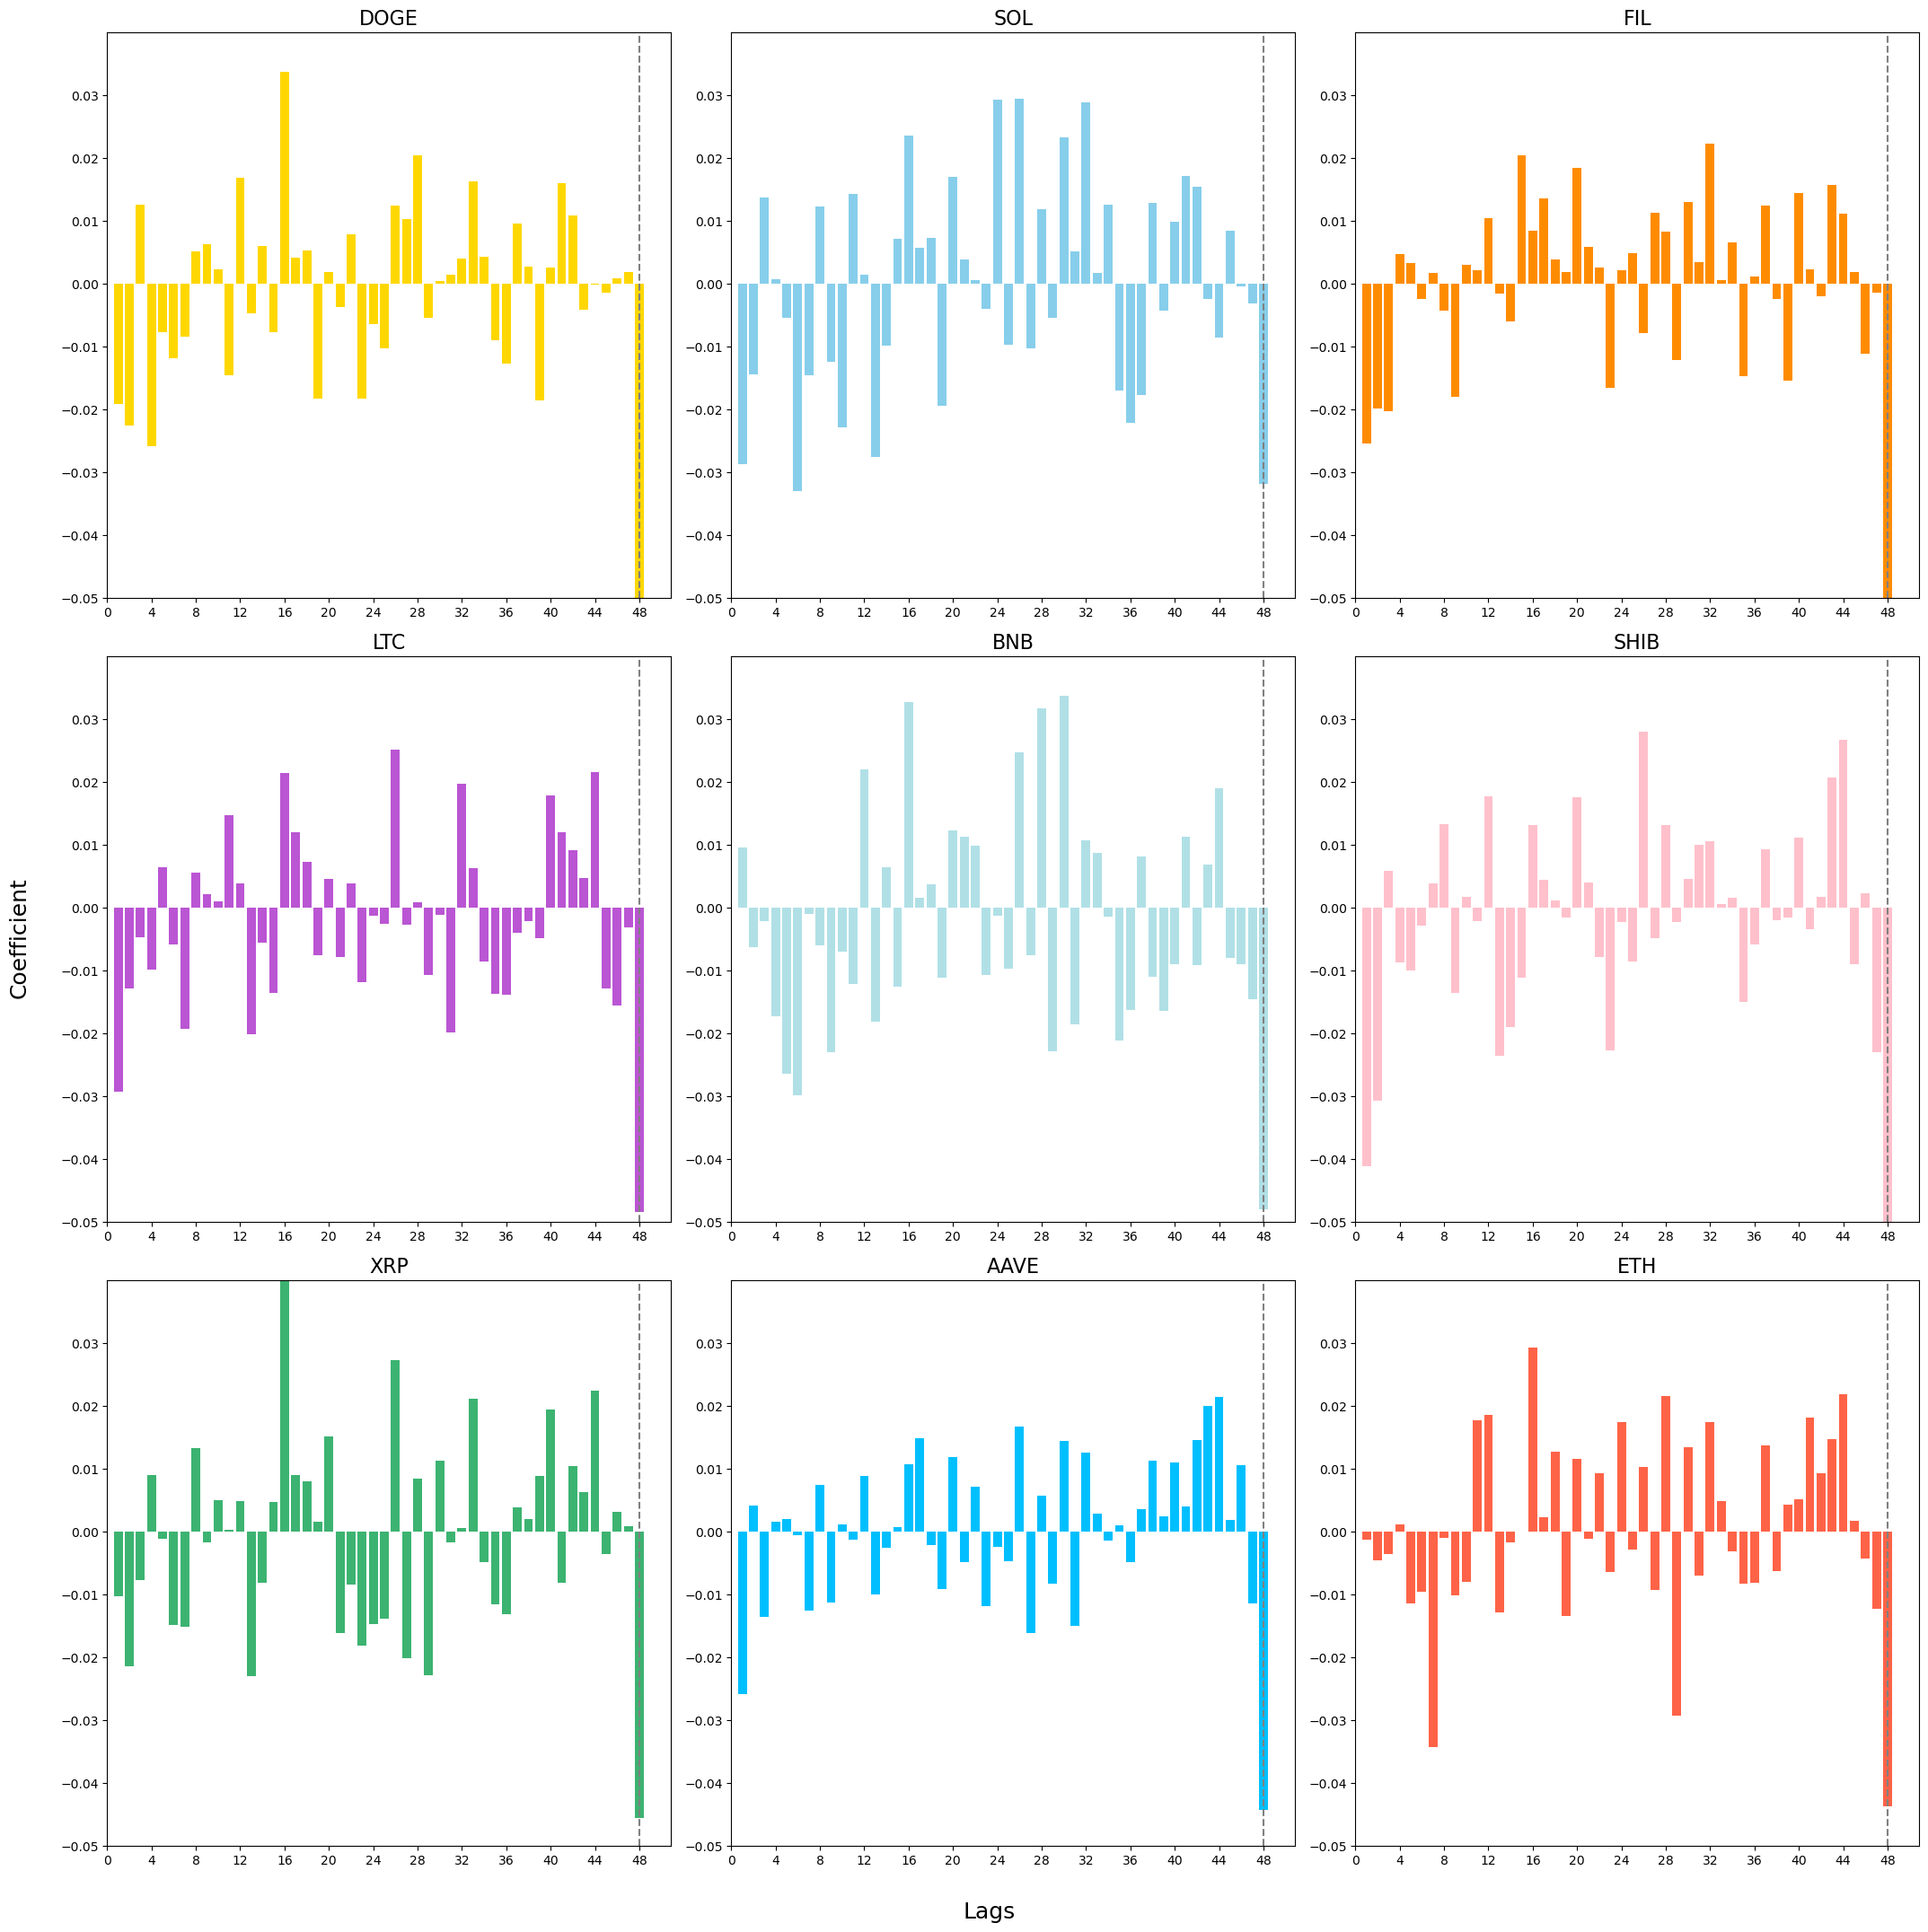

In [89]:
fig, axs = plt.subplots(3, 3, figsize=(21, 21))
colors = ['#FF6347','#FFD700','#87CEEB','#FF8C00','#BA55D3','#B0E0E6','#FFC0CB','#3CB371','#00BFFF'] 
# plot data on each subplot
for i, col in enumerate(cols):
    r, c = divmod(i-1, 3)
    lags = np.array(df_coef_9.index)[:49]
    gamma = np.array(df_coef_9[col])[:49]
    axs[r, c].bar(lags, gamma, color=colors[i])
    axs[r, c].set_title(col, fontsize=16)
    axs[r, c].set_xticks(lags[::4])
    axs[r, c].set_xlim(lags.min())
    axs[r, c].set_yticks([i/100 for i in range(-5, 4, 1)])
    axs[r, c].set_ylim(-0.05, 0.04)
    axs[r, c].axvline(x=48, color='gray', linestyle='--')
    
# set the x and y-axis labels for the entire plot
fig.text(0.5, -0.02, 'Lags', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'Coefficient', va='center', rotation='vertical', fontsize=18)

# adjust the space between subplots
plt.tight_layout()
plt.show()
fig.savefig('output/1day_estimate_for_others.jpg')

In [90]:
# build a t-value dataframe for other 9 cryptos
df_tvalue_9 = df_tvalue.set_index(np.char.upper(np.array(cryptos)))
df_tvalue_9 = df_tvalue_9.transpose()
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in list(df_tvalue_9.index)])
lags = np.insert(lags, 0, 0)
lag_0 = pd.DataFrame(columns=np.char.upper(np.array(cryptos)))
lag_0.loc[0] = [0] * 10
df_tvalue_9 = pd.concat([lag_0, df_tvalue_9])
df_tvalue_9 = df_tvalue_9.reset_index(drop=True)
df_tvalue_9 = df_tvalue_9.set_index(lags)
cols = list(df_tvalue_9.columns)
cols.pop(0)
cols

['ETH', 'DOGE', 'SOL', 'FIL', 'LTC', 'BNB', 'SHIB', 'XRP', 'AAVE']

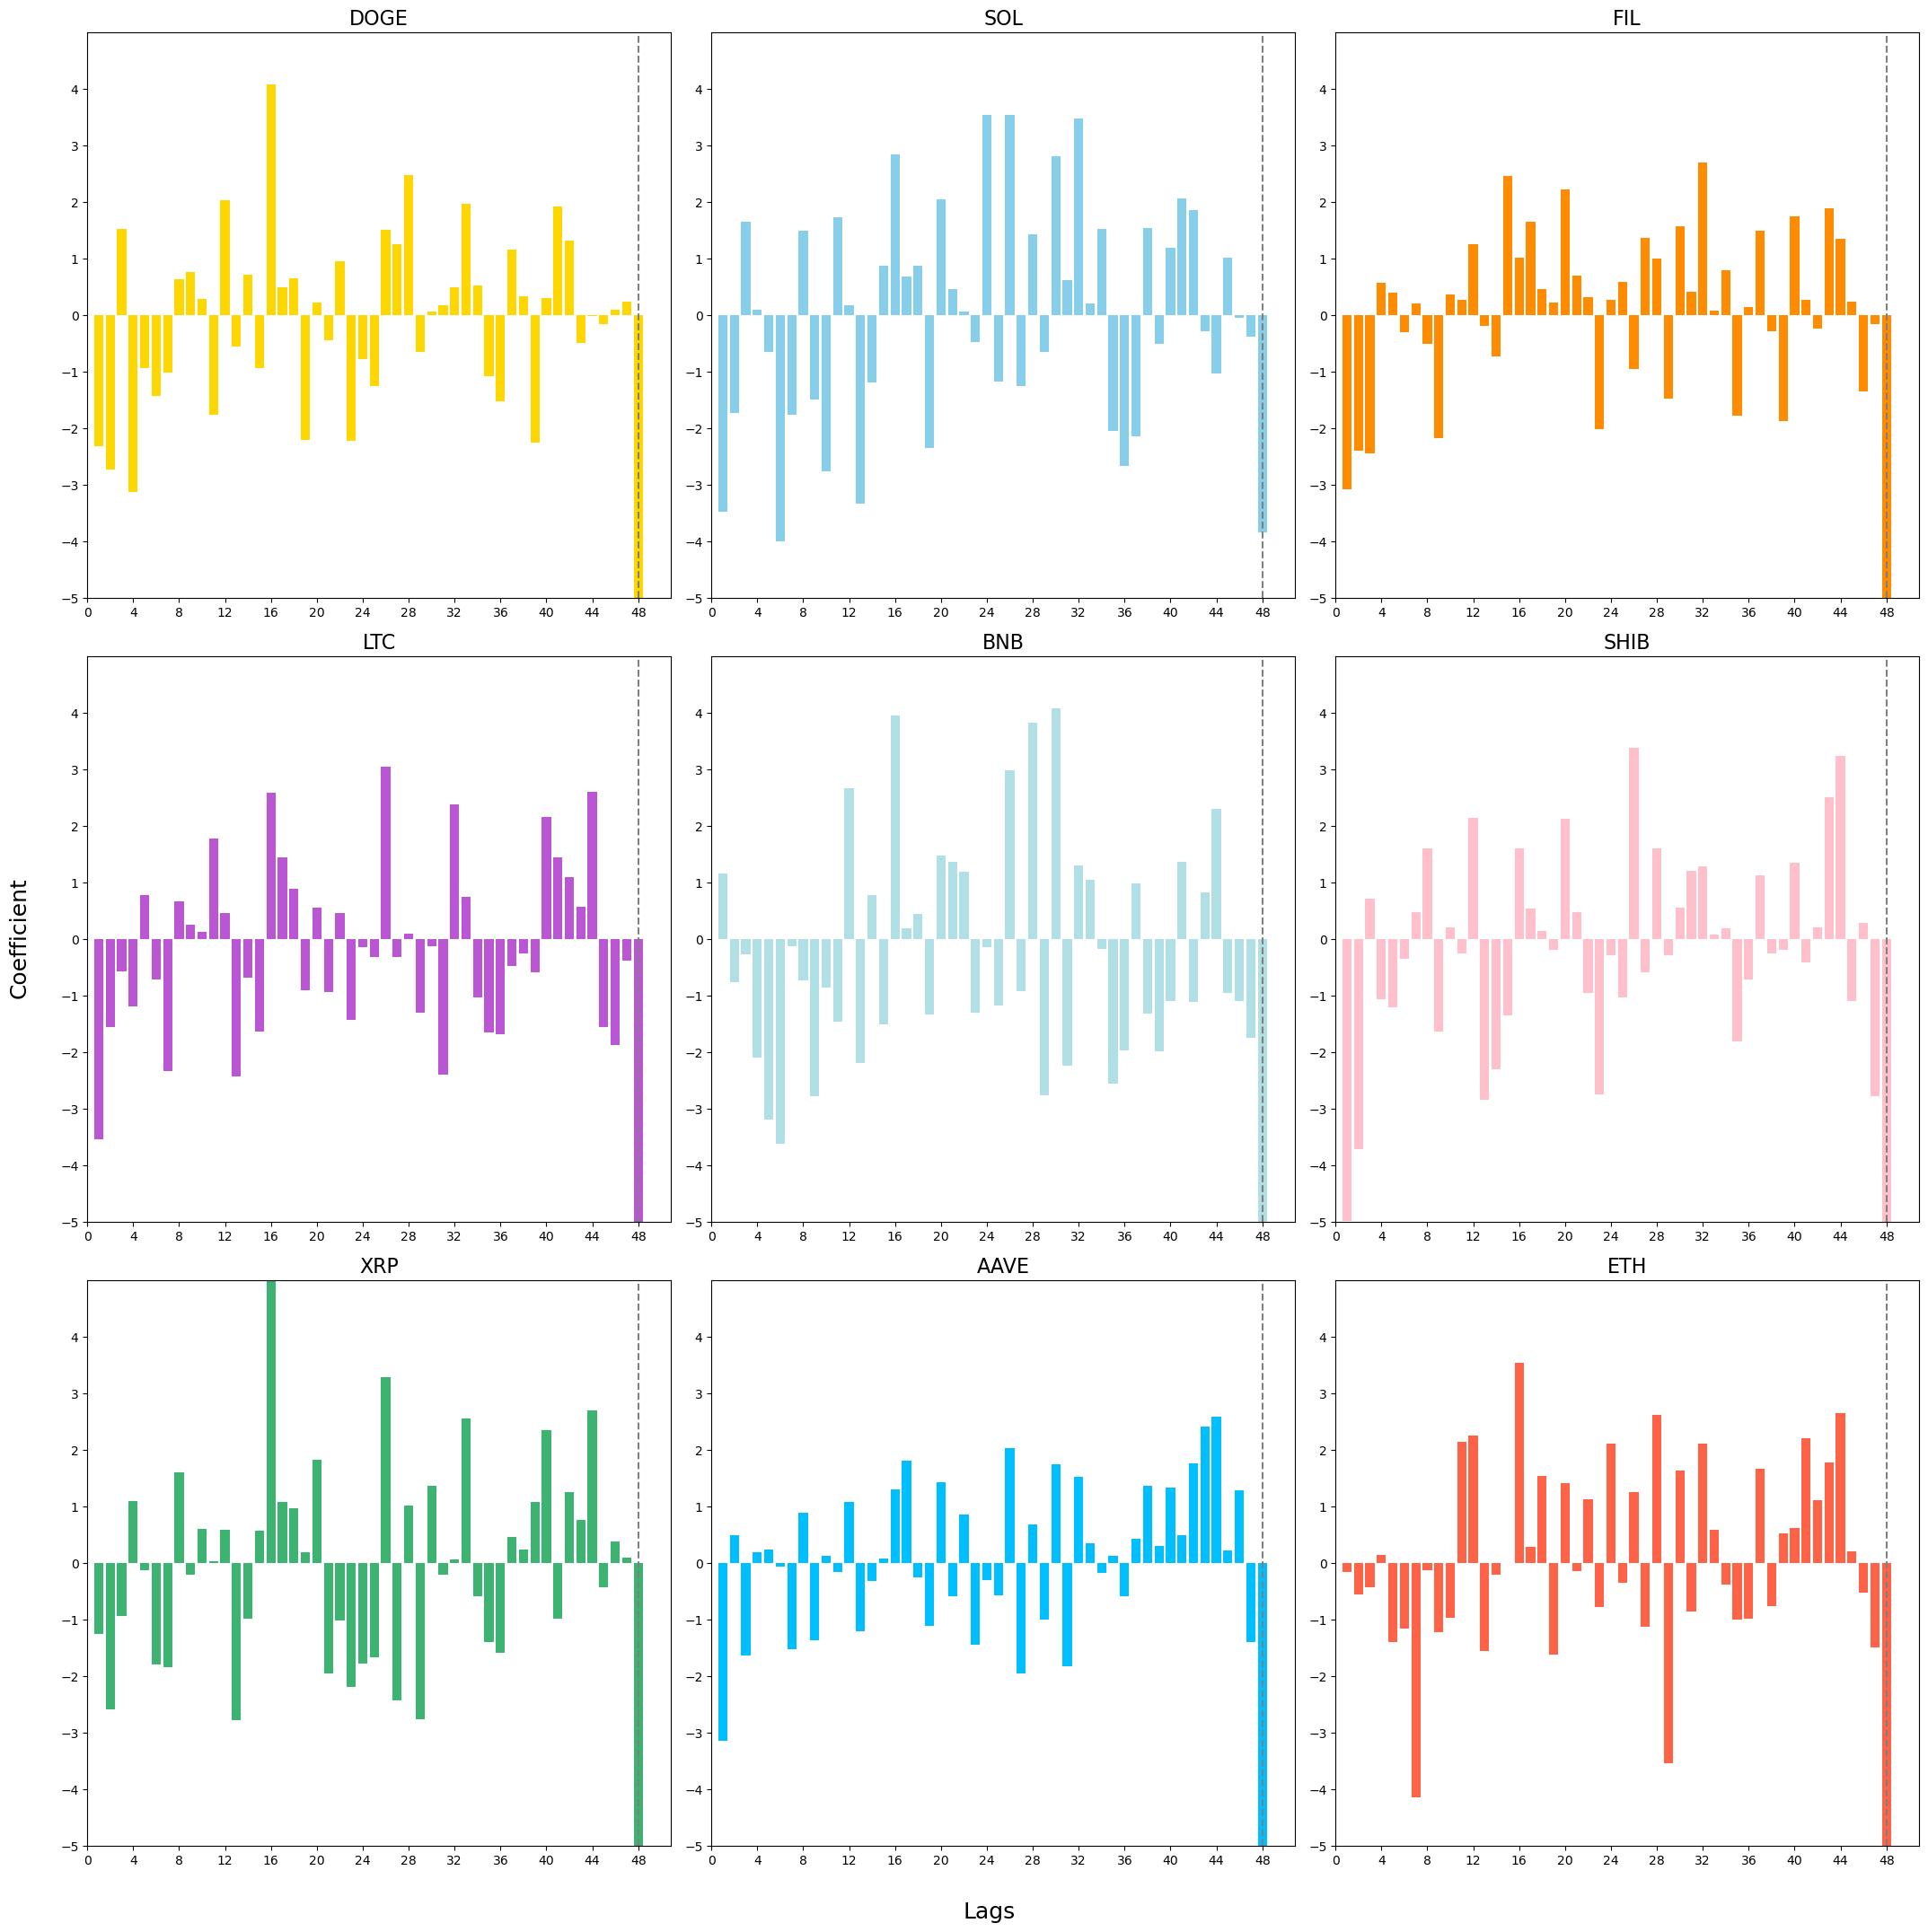

In [91]:
fig, axs = plt.subplots(3, 3, figsize=(21, 21))
colors = ['#FF6347','#FFD700','#87CEEB','#FF8C00','#BA55D3','#B0E0E6','#FFC0CB','#3CB371','#00BFFF'] 
# plot data on each subplot
for i, col in enumerate(cols):
    r, c = divmod(i-1, 3)
    lags = np.array(df_tvalue_9.index)[:49]
    gamma = np.array(df_tvalue_9[col])[:49]
    axs[r, c].bar(lags, gamma, color=colors[i])
    axs[r, c].set_title(col, fontsize=16)
    axs[r, c].set_xticks(lags[::4])
    axs[r, c].set_xlim(lags.min())
    axs[r, c].set_yticks([i for i in range(-5, 5, 1)])
    axs[r, c].set_ylim(-5, 5)
    axs[r, c].axvline(x=48, color='gray', linestyle='--')
    
# set the x and y-axis labels for the entire plot
fig.text(0.5, -0.02, 'Lags', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'Coefficient', va='center', rotation='vertical', fontsize=18)

# adjust the space between subplots
plt.tight_layout()
plt.show()
fig.savefig('output/1day_tvalue_for_others.jpg')

### Analysis for volume

In [92]:
# log the volumes before running regression
df_volumes = np.log(df_volumes)

In [93]:
df_volumes.tail()

,BTC_volume,ETH_volume,DOGE_volume,SOL_volume,FIL_volume,LTC_volume,BNB_volume,SHIB_volume,XRP_volume,AAVE_volume
timestamp,,,,,,,,,,
2022-12-31 22:00:00,7.941936,8.645585,15.834555,10.911434,10.542242,9.236671,7.661699,23.176055,14.133765,6.465373
2022-12-31 22:30:00,7.264926,7.500212,15.557170,10.056497,10.225789,8.850958,7.647696,23.130593,14.316290,4.637686
2022-12-31 23:00:00,7.719291,8.440843,16.115917,11.140373,10.137653,8.436023,7.998549,24.010685,14.499702,7.245404
2022-12-31 23:30:00,7.617585,7.482564,16.327744,10.741315,9.974838,8.034940,8.719257,24.371472,14.920871,7.996726
2023-01-01 00:00:00,7.624904,7.134474,16.005091,11.059702,9.598908,9.428447,8.323692,24.193592,15.037138,8.009335


In [94]:
# shift k lags
df_volumes['BTC_vol_lag1'] = df_volumes['BTC_volume'].shift()
df_btc_vol = df_volumes[['BTC_volume', 'BTC_vol_lag1']]
df_btc_vol.rename(columns={'BTC_volume': 'BTC_vol_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "BTC_vol_lag" + str(i)
    df_btc_vol[lag] = df_volumes['BTC_volume'].shift(i)

In [95]:
# reverse dataset for better understandding of lags
df_btc_vol_r = df_btc_vol.iloc[::-1]
# Replace 'inf' with 'NaN'
df_btc_vol_r = df_btc_vol_r.replace([np.inf, -np.inf], np.nan)
# remove missing value
df_btc_vol_r = df_btc_vol_r.dropna()

#### run simple regression for Bitcoin volumes for every time slot till lag 336 (7days)

In [96]:
# run regressions 336 times and extract the result
cols = list(df_btc_vol_r.columns)
coef, tvalue = [], []
for i in range(1, 337):
    y = df_btc_vol_r[cols[0]]
    X = df_btc_vol_r[cols[i]]
    BTC_lag1440_vol_s_reg = sm.OLS(y, X).fit()
    coef.append(BTC_lag1440_vol_s_reg.params)
    tvalue.append(BTC_lag1440_vol_s_reg.tvalues)
gamma = np.array(coef)
tstat = np.array(tvalue)
lags = np.array([int(re.findall('\d+', col)[0]) for col in cols])[:336]

In [97]:
# append date to a table
df_btc_coef = pd.DataFrame(gamma, index=lags, columns=['Coefficient'])
df_btc_tstat = pd.DataFrame(tstat, index=lags, columns=['t-Statistic'])
df_btc_table = pd.merge(df_btc_coef, df_btc_tstat, left_index=True, right_index=True)
df_btc_table = df_btc_table.reset_index().rename(columns={'index': 'Lag'})

In [98]:
# split DataFrame into smaller DataFrames of size 48
df_btc_table_48s = np.array_split(df_btc_table, len(df_btc_table) // 48)
df_btc_merged =  df_btc_table_48s[0]
df_btc_merged = df_btc_merged.reset_index(drop=True)
for i in range(1, len(df_btc_table_48s)):
    df_temp = df_btc_table_48s[i].reset_index(drop=True)
    df_btc_merged = pd.merge(df_btc_merged, df_temp, left_index=True, right_index=True)
df_btc_merged = df_btc_merged.rename(columns=lambda x: x.replace('_x', '').replace('_y', ''))

In [99]:
df_btc_merged

,Lag,Coefficient,t-Statistic,Lag,Coefficient,t-Statistic,Lag,Coefficient,t-Statistic,Lag,...,t-Statistic,Lag,Coefficient,t-Statistic,Lag,Coefficient,t-Statistic,Lag,Coefficient,t-Statistic
0,0,0.998063,1938.259228,48,0.995177,1201.839229,96,0.994866,1079.081926,144,...,1054.942367,192,0.996207,1047.931633,240,0.996651,1031.284680,288,0.997844,1092.350567
1,1,0.997129,1590.950753,49,0.995056,1185.718731,97,0.994767,1068.434222,145,...,1048.591537,193,0.996172,1044.738089,241,0.996620,1027.622834,289,0.997758,1083.810780
2,2,0.996682,1479.439038,50,0.994893,1166.232137,98,0.994672,1058.237020,146,...,1045.250827,194,0.996085,1036.696478,242,0.996503,1018.764218,290,0.997642,1072.124293
3,3,0.996386,1419.203136,51,0.994795,1154.729623,99,0.994605,1051.182467,147,...,1041.909355,195,0.996021,1029.844398,243,0.996446,1014.180716,291,0.997607,1067.634766
4,4,0.996097,1365.542605,52,0.994579,1131.324879,100,0.994487,1040.321051,148,...,1033.789178,196,0.995924,1020.038365,244,0.996356,1007.007760,292,0.997503,1057.869508
5,5,0.995902,1333.189432,53,0.994430,1115.445952,101,0.994417,1032.455306,149,...,1026.217143,197,0.995867,1013.968609,245,0.996274,1000.166398,293,0.997459,1052.994269
6,6,0.995717,1304.010154,54,0.994332,1105.159908,102,0.994370,1026.918595,150,...,1019.539414,198,0.995862,1011.694243,246,0.996203,994.533602,294,0.997429,1048.772863
7,7,0.995570,1281.773871,55,0.994294,1100.715205,103,0.994358,1024.410158,151,...,1017.370438,199,0.995899,1012.119603,247,0.996220,995.153203,295,0.997449,1048.642261
8,8,0.995435,1264.306380,56,0.994225,1094.307493,104,0.994359,1023.001392,152,...,1012.436127,200,0.995825,1005.378586,248,0.996168,990.196586,296,0.997384,1041.935995
9,9,0.995363,1253.900158,57,0.994145,1087.301826,105,0.994339,1019.525792,153,...,1007.743979,201,0.995781,1000.746905,249,0.996196,990.579741,297,0.997395,1041.882461


Under simple regerssion, i.e. run 336 regressions for different independent variable (different lag k). All coefficients are near to 1, this is may due to volume persistency

#### BTC - represents other PoW (proof of work) currencies

Plot Bitcoin volume estimates of cross-sectional regressions (multiple regression, all independent variable in a same regression)

In [100]:
# run multiple regression for Bitcoin volumes to see if there is a different result
log_cols = list(df_btc_vol_r.columns)
y = df_btc_vol_r[log_cols.pop(0)]
X = df_btc_vol_r[log_cols]
X = sm.add_constant(X)
# run regression for volumes
BTC_lag1440_vol_reg = sm.OLS(y, X).fit()

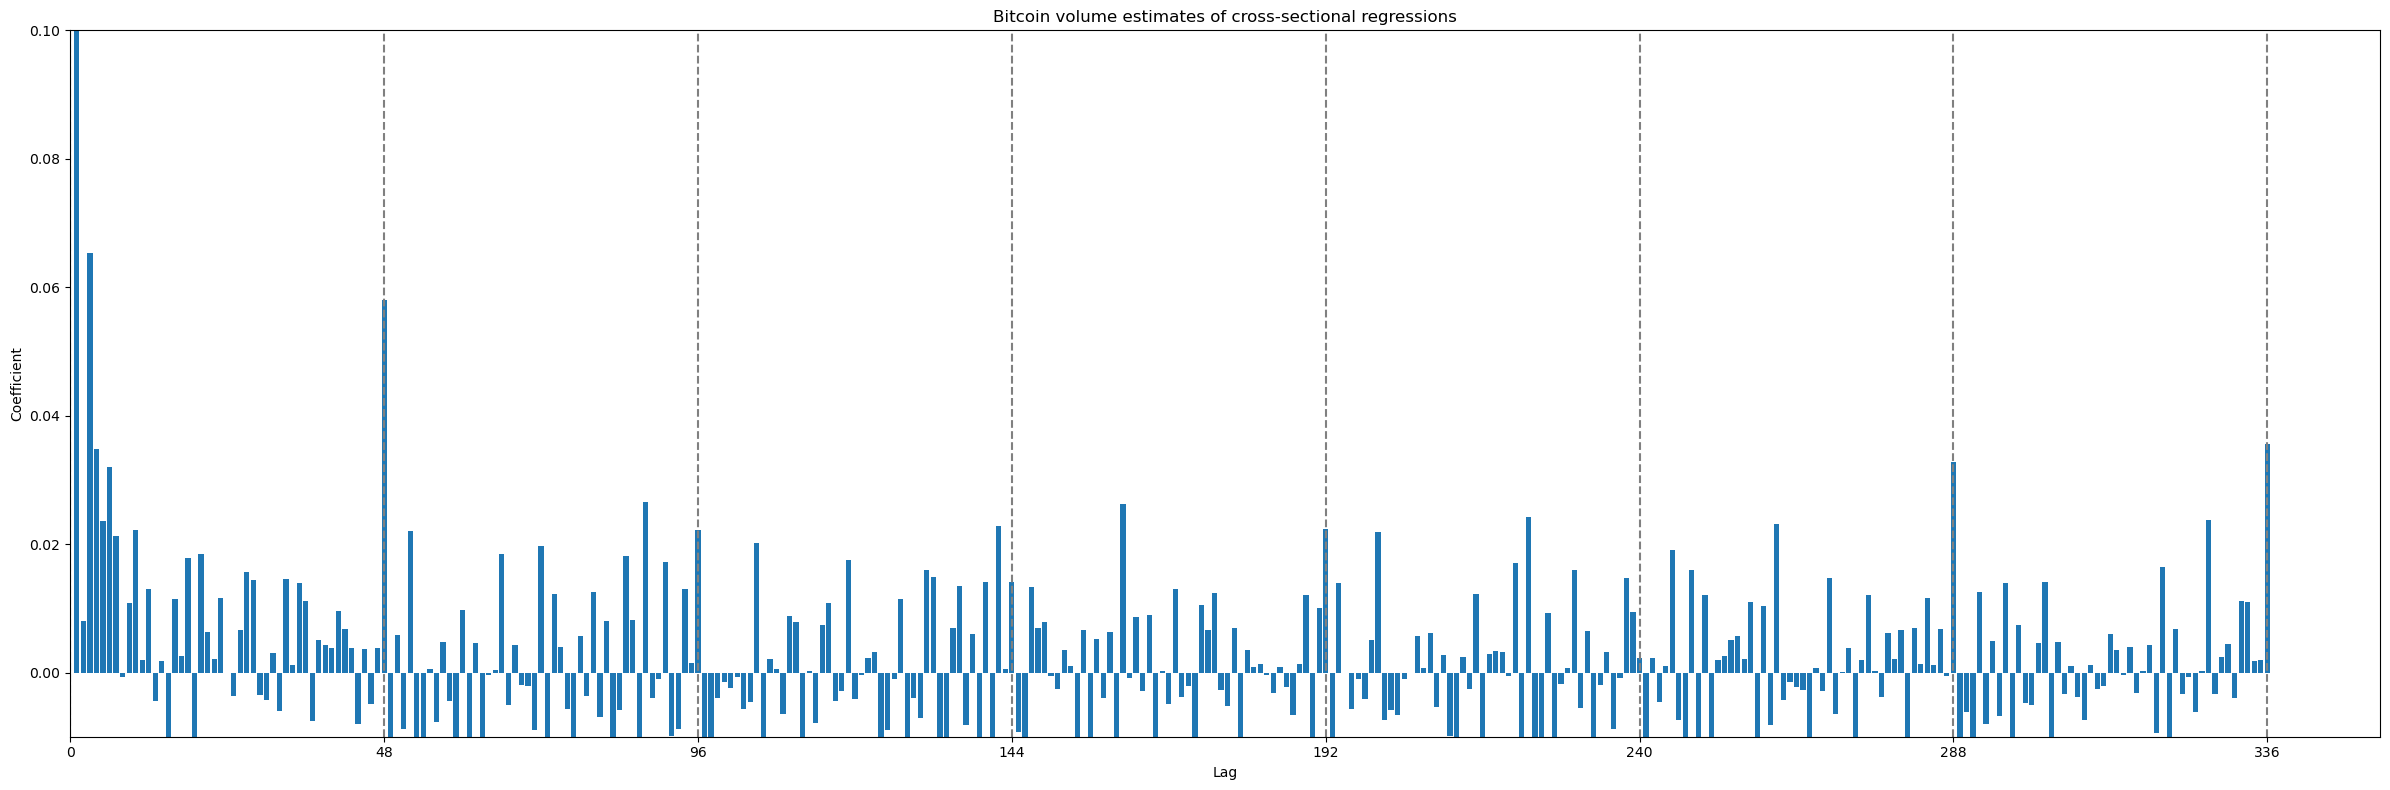

In [101]:
# Extract coefficients
coef_btc = BTC_lag1440_vol_reg.params
# Delete intercept coef
gamma = np.delete(coef_btc.values, 0)
gamma = np.insert(gamma, 0, 0)
lags = np.delete(coef_btc.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma)
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
ax.set_ylim(-0.01, 0.1)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Bitcoin volume estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [102]:
# store t-stat for later use
tvalue_btc = BTC_lag1440_vol_reg.tvalues

#### Two findings
    - high coefficient of lag 1, up to arount 0.5
    - relativelt significant coefficient of lag 48, same finding as returns

#### FIL - represents other PoST (proof of space and time) currencies

In [103]:
# shift k lags
df_volumes['FIL_vol_lag1'] = df_volumes['FIL_volume'].shift()
df_fil_vol = df_volumes[['FIL_volume', 'FIL_vol_lag1']]
df_fil_vol.rename(columns={'FIL_volume': 'FIL_vol_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "FIL_vol_lag" + str(i)
    df_fil_vol[lag] = df_volumes['FIL_volume'].shift(i)
# reverse dataset for better understandding of lags
df_fil_vol_r = df_fil_vol.iloc[::-1]
# Replace 'inf' with 'NaN'
df_fil_vol_r = df_fil_vol_r.replace([np.inf, -np.inf], np.nan)
# remove missing value
df_fil_vol_r = df_fil_vol_r.dropna()
# Specify the dependent and independent variables
lag_cols = list(df_fil_vol_r.columns)
y = df_fil_vol_r[lag_cols.pop(0)]
X = df_fil_vol_r[lag_cols]
X = sm.add_constant(X) 
# run regression for volumes
FIL_lag1440_vol_reg = sm.OLS(y, X).fit()

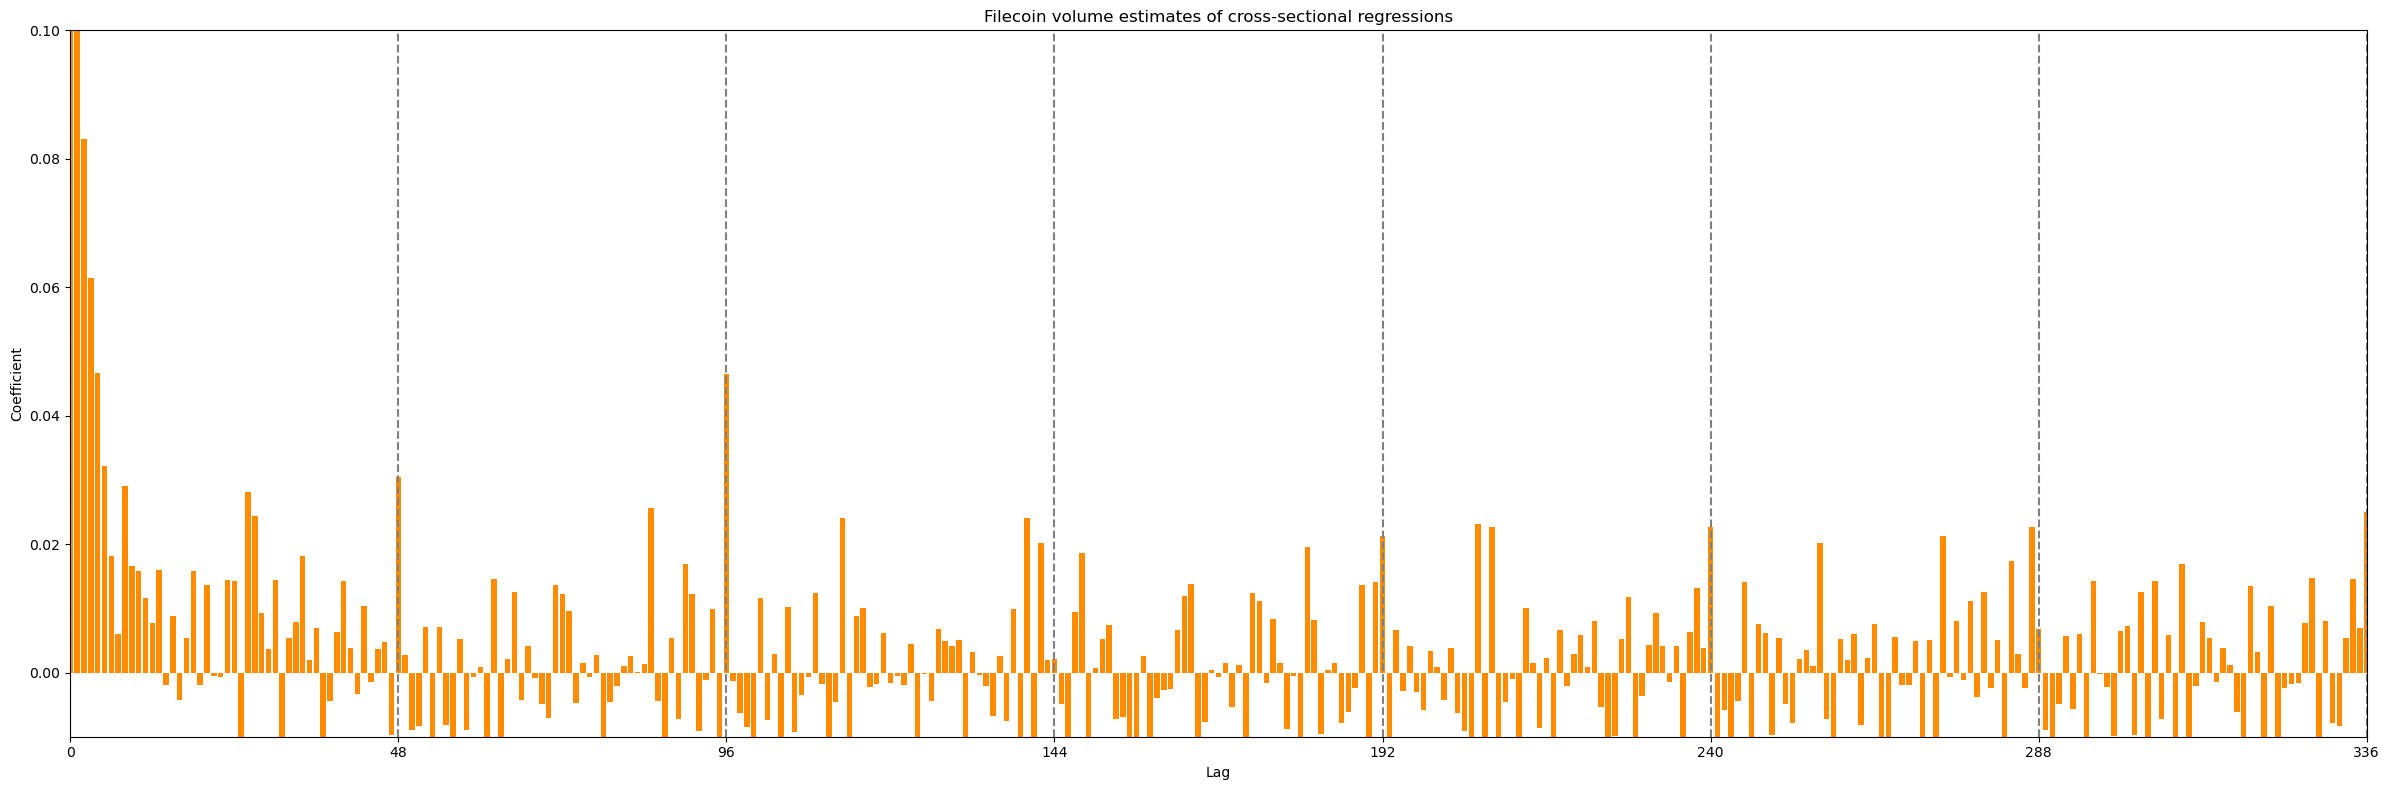

In [104]:
# Extract coefficients
coef_fil = FIL_lag1440_vol_reg.params
# Delete intercept coef
gamma = np.delete(coef_fil.values, 0)
gamma = np.insert(gamma, 0, 1)
lags = np.delete(coef_fil.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma, color='#FF8C00')
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
ax.set_ylim(-0.01, 0.1)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Filecoin volume estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

In [105]:
# store t-stat for later use
tvalue_fil = FIL_lag1440_vol_reg.tvalues

#### AAVE  - represents other low volume currencies

In [106]:
# shift k lags
df_volumes['AAVE_vol_lag1'] = df_volumes['AAVE_volume'].shift()
df_aave_vol = df_volumes[['AAVE_volume', 'AAVE_vol_lag1']]
df_aave_vol.rename(columns={'AAVE_volume': 'AAVE_vol_lag0'}, inplace=True)
for i in range(2, 1441):
    lag = "AAVE_vol_lag" + str(i)
    df_aave_vol[lag] = df_volumes['AAVE_volume'].shift(i)
# reverse dataset for better understandding of lags
df_aave_vol_r = df_aave_vol.iloc[::-1]
# Replace 'inf' with 'NaN'
df_aave_vol_r = df_aave_vol_r.replace([np.inf, -np.inf], np.nan)
# remove missing value
df_aave_vol_r = df_aave_vol_r.dropna()
# Specify the dependent and independent variables
log_cols = list(df_aave_vol_r.columns)
y = df_aave_vol_r[log_cols.pop(0)]
X = df_aave_vol_r[log_cols]
X = sm.add_constant(X) 
# run regression for volumes
AAVE_lag1440_vol_reg = sm.OLS(y, X).fit()

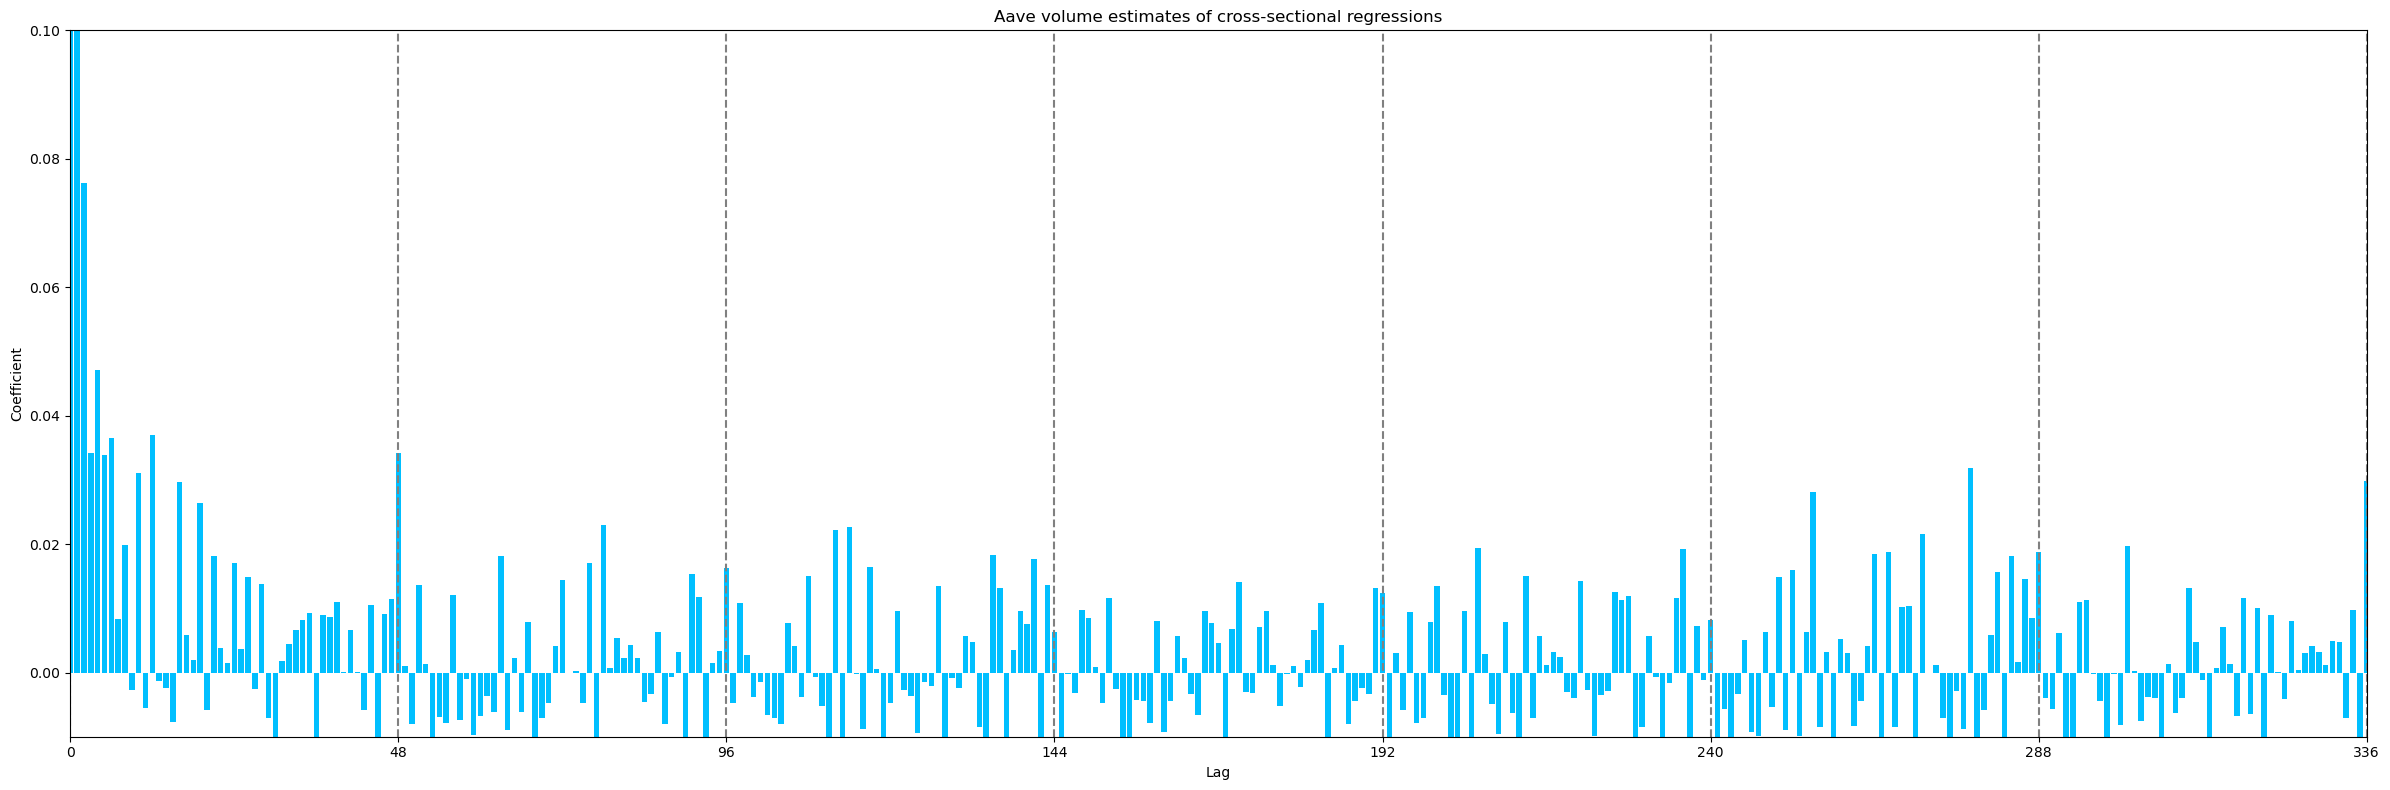

In [107]:
# Extract coefficients
coef_aave = AAVE_lag1440_vol_reg.params
# Delete intercept coef
gamma = np.delete(coef_aave.values, 0)
gamma = np.insert(gamma, 0, 1)
lags = np.delete(coef_aave.index, 0)
lags = np.array([int(re.findall('\d+', lag)[0]) for lag in lags])
lags = np.insert(lags, 0, 0)
# Create a bar plot
gamma = gamma[:337]
lags = lags[:337]
fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(lags, gamma, color='#00BFFF')
ax.set_ylabel('Coefficient')
ax.set_xlabel('Lag')
# set the y limit
ax.set_ylim(-0.01, 0.1)
# set the x ticks
ax.set_xticks(lags[::48])
ax.set_xlim(lags.min(), lags.max())
# insert vertical lines for plot
xticks = ax.get_xticks()
for xtick in xticks:
    ax.axvline(x=xtick, color='gray', linestyle='--')
ax.set_title('Aave volume estimates of cross-sectional regressions')
fig.tight_layout()
plt.show()

Same evidence as Bitcoin and Filecoin

In [108]:
# save df_returns for investment strategy usage
df_returns.to_csv('data/returns_data.csv', index=True)